# Kanban Metrics

This is an experiment of using Jira issue changelogs to compute a historical record of a Kanban, then using that historical record to run Kaplan-Meier and Weibull survivability models and Monte Carlo simulations to gauge:

1. how likely will a single issue be completed in N days
2. how much work a team can take on over the next N days
3. and by what date N number of work items could be completed


---

## Data Prep

First, let's read in some [Jira changelog data](example.csv). We do this by using the [jira.py](jira.py) utility included in this repository to export issue data directly from the Jira REST API. 

In [1]:
import analysis
analysis.init()

In [2]:
import matplotlib
import pandas
import seaborn

import collections

OMIT_ISSUE_TYPES = ('Epic',)
FILTER_ISSUES_UNTIL = '2020-08-25'
FILTER_ISSUES_SINCE = (pandas.to_datetime(FILTER_ISSUES_UNTIL) - pandas.Timedelta(days=90)).strftime('%Y-%m-%d')
EXCLUDE_WEEKENDS = True

DATA_FILE = 'data/example.csv'
STATUS_ORDER = ['Prioritized', 'In Preparation', 'In Progress', 'Review', 'Accepted', 'Deployed']

data, dupes, filtered = analysis.read_data(DATA_FILE, since=FILTER_ISSUES_SINCE, until=FILTER_ISSUES_UNTIL)
data.head()

,project_id,project_key,issue_id,issue_key,issue_type_id,issue_type_name,issue_created_date,changelog_id,status_from_id,status_from_name,status_to_id,status_to_name,status_from_category_name,status_to_category_name,status_change_date,issue_points
0,1,PRJ,55840,PRJ-1161,10004,Bug,2020-06-01 15:49:02.582,381910.0,10000.0,To Do,3.0,In Progress,To Do,In Progress,2020-06-01 22:51:25.761,1
1,1,PRJ,55840,PRJ-1161,10004,Bug,2020-06-01 15:49:02.582,383545.0,3.0,In Progress,10017.0,Review,In Progress,In Progress,2020-06-03 19:02:26.924,1
2,1,PRJ,55840,PRJ-1161,10004,Bug,2020-06-01 15:49:02.582,384710.0,10017.0,Review,10016.0,Deployed,In Progress,Done,2020-06-08 12:13:02.847,1
3,1,PRJ,55841,PRJ-1162,10004,Bug,2020-06-01 15:49:37.672,396111.0,10000.0,To Do,10115.0,Prioritized,To Do,To Do,2020-06-24 14:18:03.760,1
4,1,PRJ,55841,PRJ-1162,10004,Bug,2020-06-01 15:49:37.672,396114.0,10115.0,Prioritized,10000.0,To Do,To Do,To Do,2020-06-24 14:19:02.728,1


In [3]:
f"{dupes} duplicates dropped from dataset"

'0 duplicates dropped from dataset'

In [4]:
collections.Counter(data['issue_type_name'].values)

Counter({'Bug': 192, 'Task': 224, 'Story': 147, 'Epic': 10})

In [5]:
collections.Counter(list(data['status_from_name'].values) + list(data['status_to_name'].values))

Counter({'To Do': 188,
         'In Progress': 226,
         'Review': 180,
         'Prioritized': 257,
         nan: 120,
         'Accepted': 47,
         "Can't Fix": 23,
         'Backlog': 1,
         'Deployed': 104})

Now that we have the data, let's coallesce the changelogs into individual issues changelogs for easy lookup.

What we want to be able to do at this point is to know the total time an issue spends in the "In Progress" state. We could take a look at all of the state changes and compute the sum of the time residing in the "In Progess" state. An alternative that is easier to compute (with less accuracy) is to track when the issue was first created, when it first moved into work in progress, and when it finally completed, ignoring other state transitions in between.

To do this without having to map each status, we use the Jira "status_category_name", which is an ENUM:

* To Do
* In Progress
* Done

Finally, we create a new data set of each issue with the dates when the state changes happened. We also compute the lead and cycle times of each issue.

In [6]:
issue_data, (categories, *extra) = analysis.process_issue_data(data, exclude_weekends=EXCLUDE_WEEKENDS)
issue_data.head(5)

,issue_type,issue_points,new,new_day,in_progress,in_progress_day,complete,complete_day,lead_time,lead_time_days,cycle_time,cycle_time_days,prev_issue_status,prev_issue_status_change_date,prev_issue_status_category,last_issue_status,last_issue_status_change_date,last_issue_status_category
issue_key,,,,,,,,,,,,,,,,,,
PRJ-1161,Bug,1,2020-06-01 15:49:02.582,2020-06-01,2020-06-01 22:51:25.761000,2020-06-01,2020-06-08 12:13:02.847000,2020-06-08,4 days 20:24:00.265000,4.850003,4 days 13:21:37.086000,4.556679,Review,2020-06-03 19:02:26.924,In Progress,Deployed,2020-06-08 12:13:02.847,Done
PRJ-1162,Bug,1,2020-06-01 15:49:37.672,2020-06-01,None,NaT,2020-06-30 16:40:10.782000,2020-06-30,21 days 00:50:33.110000,21.035105,0 days 00:00:00,0.000000,To Do,2020-06-24 14:19:02.728,To Do,Can't Fix,2020-06-30 16:40:10.782,Done
PRJ-1163,Bug,1,2020-06-01 15:50:51.594,2020-06-01,2020-06-01 16:43:45.490000,2020-06-01,2020-06-02 15:10:07.725000,2020-06-02,0 days 23:19:16.131000,0.971714,0 days 22:26:22.235000,0.934980,In Progress,2020-06-01 16:43:45.490,In Progress,Deployed,2020-06-02 15:10:07.725,Done
PRJ-1164,Bug,1,2020-06-01 18:21:09.124,2020-06-01,2020-06-09 19:06:37.082000,2020-06-09,2020-06-10 17:00:50.078000,2020-06-10,6 days 22:39:40.954000,6.944224,0 days 21:54:12.996000,0.912650,Review,2020-06-09 19:06:37.082,In Progress,Deployed,2020-06-10 17:00:50.078,Done
PRJ-1166,Task,1,2020-06-02 14:00:13.820,2020-06-02,2020-06-02 14:01:03.861000,2020-06-02,2020-06-08 14:19:57.669000,2020-06-08,4 days 00:19:43.849000,4.013702,4 days 00:18:53.808000,4.013123,In Progress,2020-06-02 14:01:03.861,In Progress,Deployed,2020-06-08 14:19:57.669,Done


In [7]:
categories

defaultdict(set,
            {'In Progress': {'Accepted', 'In Progress', 'Review'},
             'To Do': {'Backlog', 'Prioritized', 'To Do'},
             'Done': {"Can't Fix", 'Deployed'}})


---


## Metrics

Let's take a brief look at some basic Kanban metrics, like Cycle Time & Throughput.

### Cycle Time

Cycle Time is the amount of time an issue spends "In Progress".

In other words, it's the total duration from the moment an issue is started until it is is finished.

In [8]:
cycle_data = analysis.process_cycle_data(issue_data)

cycle_data.head()

,In Progress Date,Complete Date,Cycle Time,Moving Average (10 items),Moving Standard Deviation (10 items),Average,Standard Deviation
Work Item,,,,,,,
PRJ-1163,2020-06-01,2020-06-02,0.934980,NaN,NaN,3.8903,5.040107
PRJ-1161,2020-06-01,2020-06-08,4.556679,NaN,NaN,3.8903,5.040107
PRJ-1179,2020-06-04,2020-06-08,1.952259,NaN,NaN,3.8903,5.040107
PRJ-1171,2020-06-02,2020-06-08,4.005666,NaN,NaN,3.8903,5.040107
PRJ-1166,2020-06-02,2020-06-08,4.013123,NaN,NaN,3.8903,5.040107


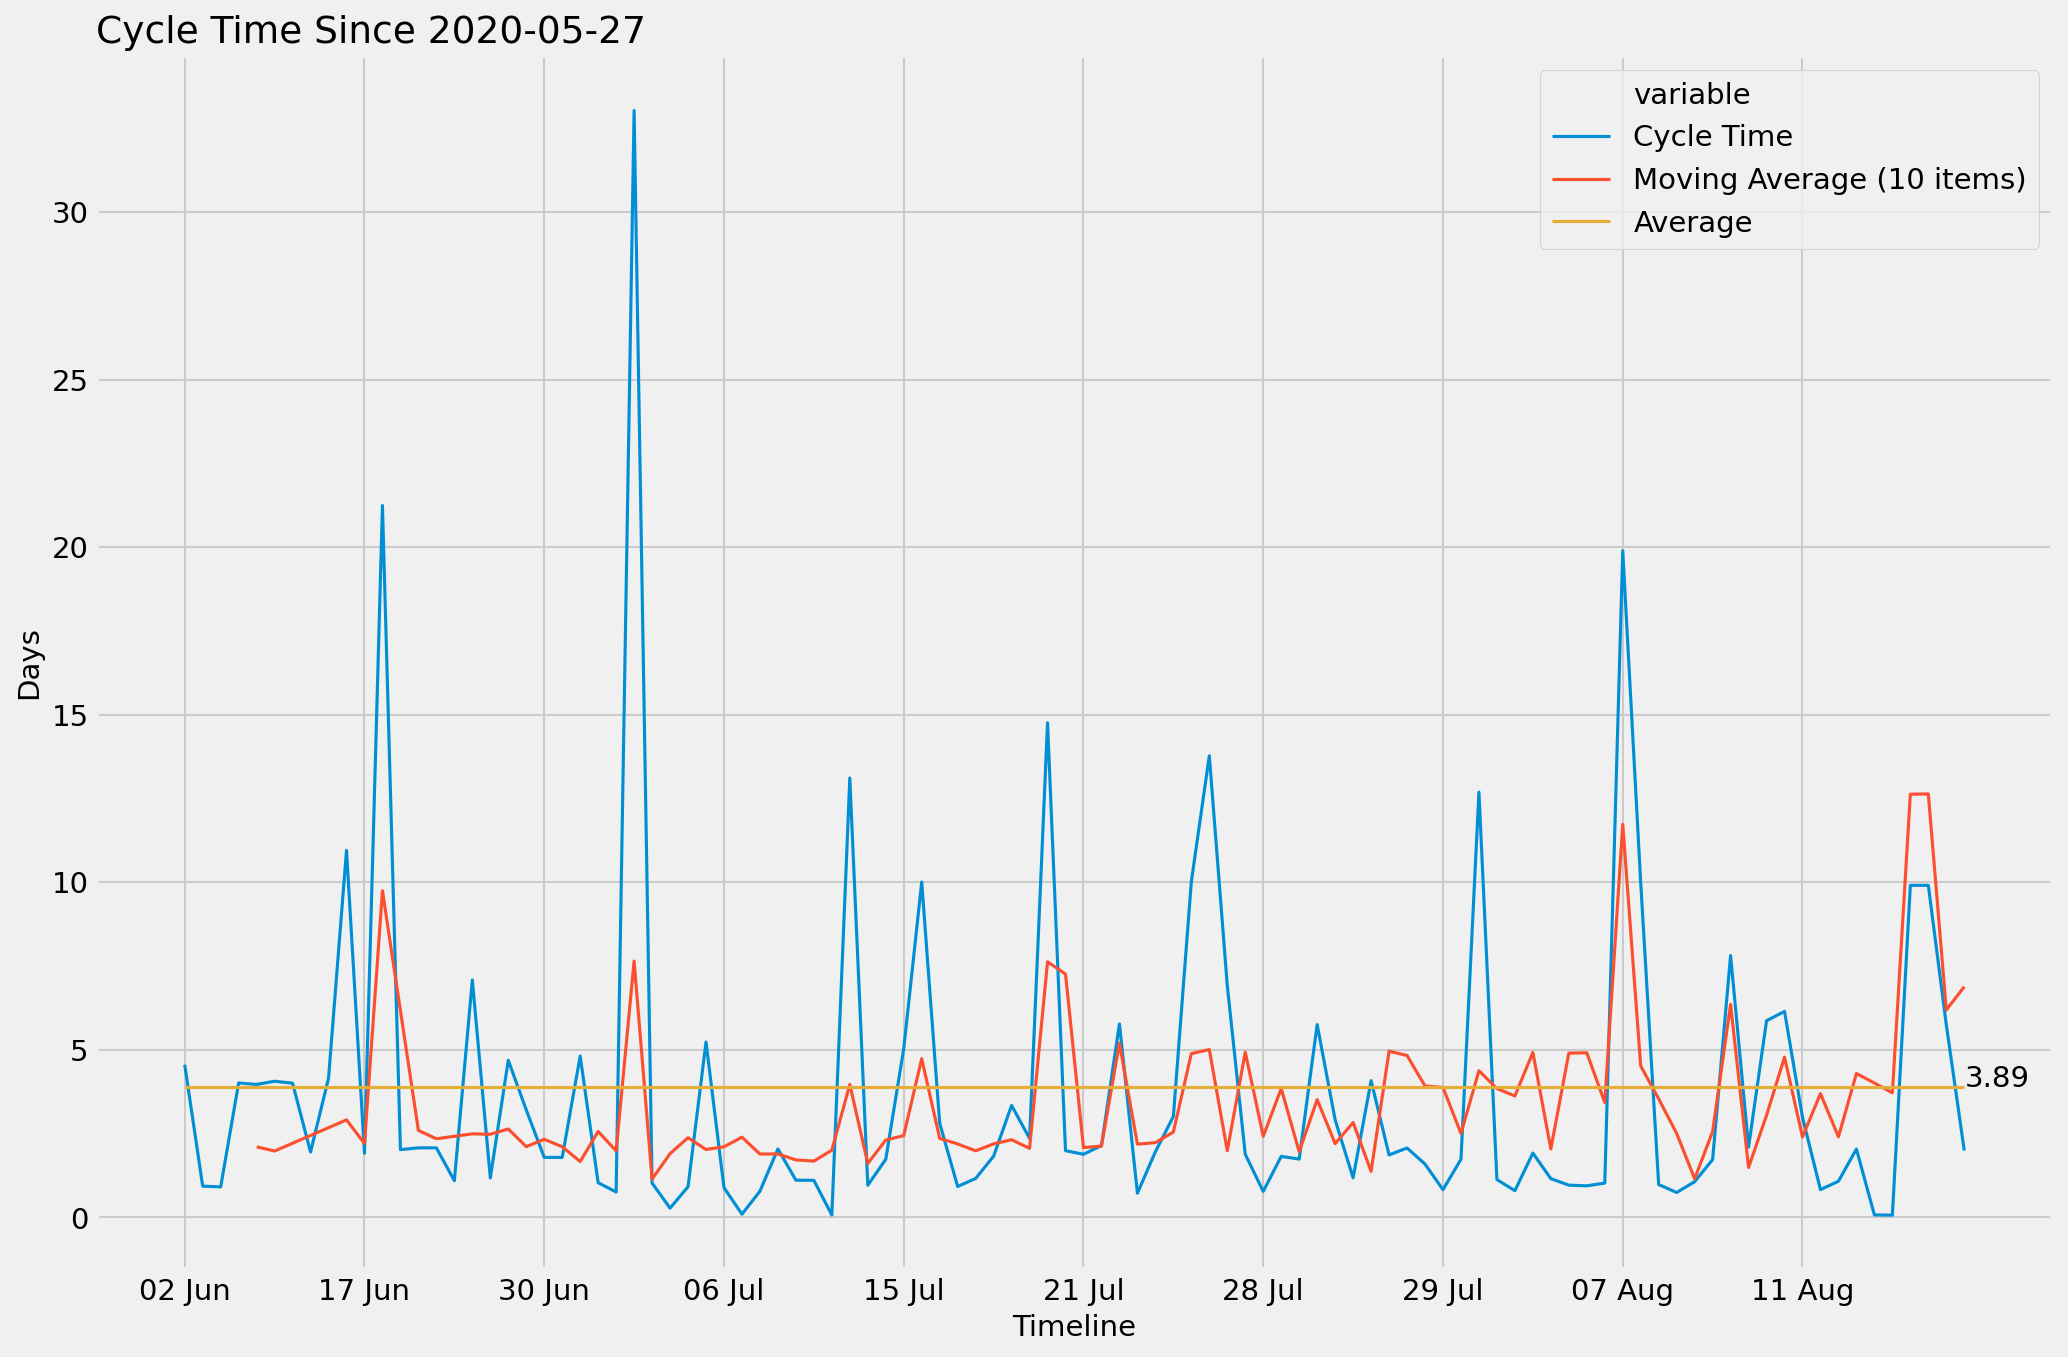

In [9]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

cycle_data = cycle_data.reset_index()

ax = seaborn.lineplot(x='Work Item', y='value', hue='variable', data=pandas.melt(cycle_data[['Work Item', 'Cycle Time', 'Moving Average (10 items)', 'Average']], ['Work Item']))

ax.set_title("Cycle Time Since {}".format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'normal'})

ax.set_xlabel('Timeline')
ax.set_ylabel('Days')

key_ticks = range(0, len(cycle_data['Work Item']), len(cycle_data['Work Item'])//10)

ax.set_xticks(key_ticks)

def format_func(value, tick_number):
    return pandas.to_datetime(cycle_data['Complete Date'].values[value]).strftime('%d %b')
ax.xaxis.set_major_formatter(matplotlib.pyplot.FuncFormatter(format_func))

_ = ax.text(cycle_data['Work Item'].max(), cycle_data['Average'].max(), "{:.2f}".format(cycle_data['Average'].max()))

In [10]:
ax.figure.savefig('images/cycletime-timeline.png', dpi=150)

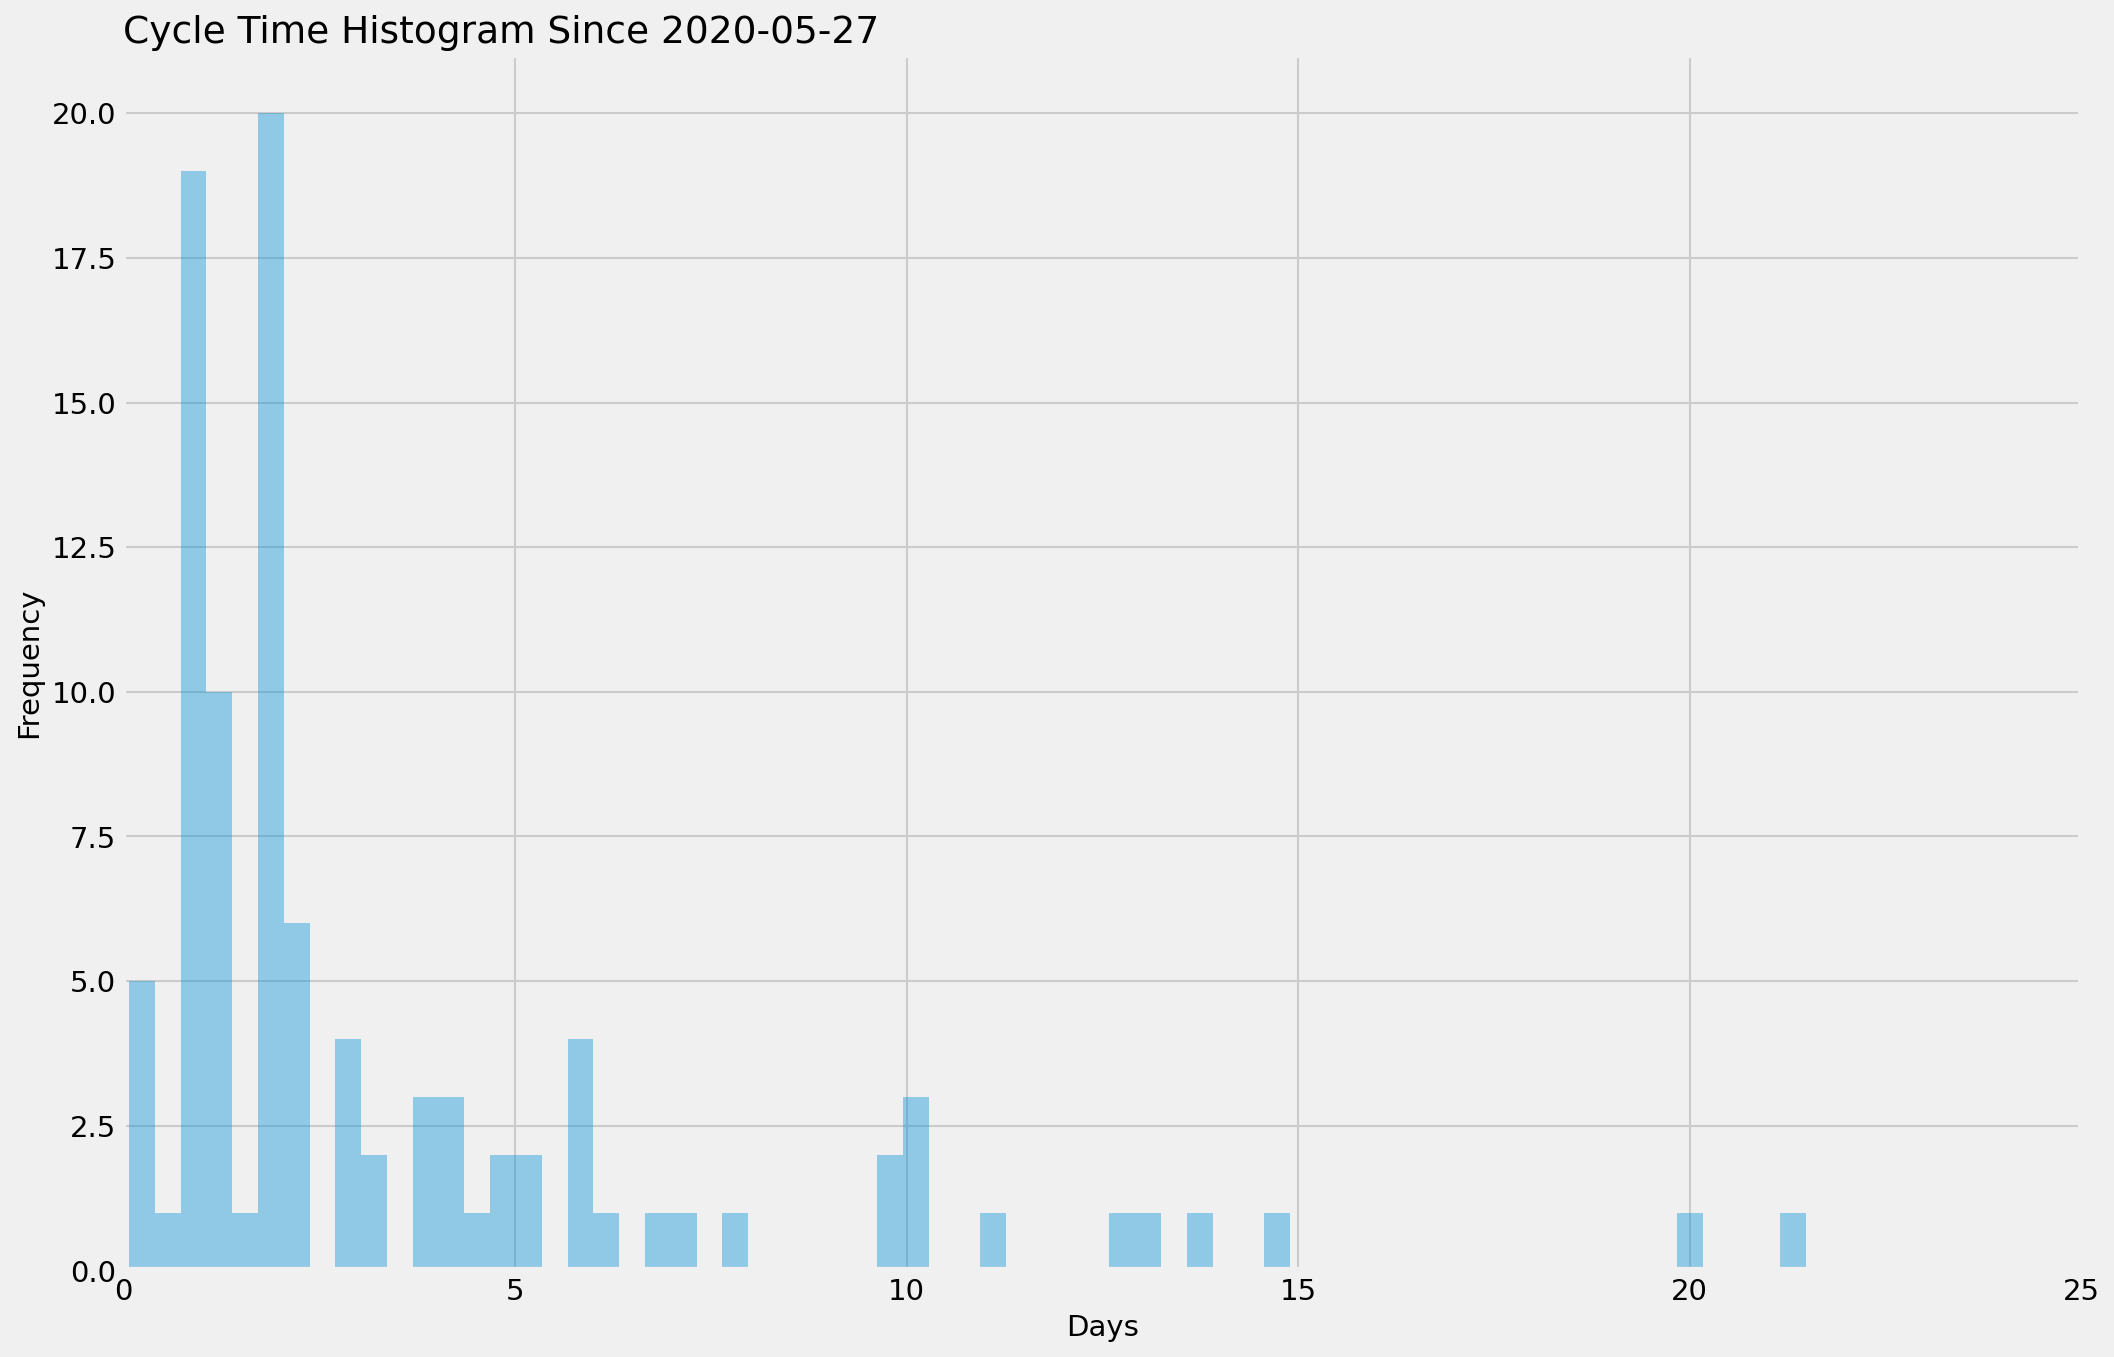

In [11]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.distplot(cycle_data['Cycle Time'], bins=100, kde=False)

ax.set_title("Cycle Time Histogram Since {}".format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'normal'})

ax.set_ylabel('Frequency')
ax.set_xlabel('Days')
_ = ax.set_xlim([0, 25])

In [12]:
ax.figure.savefig('images/cycletime-histogram.png')

### Throughput

Throughput is the number of issues completed in a given week.

In [13]:
throughput, throughput_per_week = analysis.process_throughput_data(issue_data, since=FILTER_ISSUES_SINCE, until=FILTER_ISSUES_UNTIL)
throughput_per_week.head(52)

,Throughput,Moving Average (4 weeks),Moving Standard Deviation (4 weeks),Average,Standard Deviation
Date,,,,,
2020-06-01,0,NaN,NaN,8.538462,5.48658
2020-06-08,7,NaN,NaN,8.538462,5.48658
2020-06-15,5,NaN,NaN,8.538462,5.48658
2020-06-22,7,4.75,3.304038,8.538462,5.48658
2020-06-29,5,6.00,1.154701,8.538462,5.48658
2020-07-06,18,8.75,6.238322,8.538462,5.48658
2020-07-13,5,8.75,6.238322,8.538462,5.48658
2020-07-20,13,10.25,6.396614,8.538462,5.48658
2020-07-27,8,11.00,5.715476,8.538462,5.48658


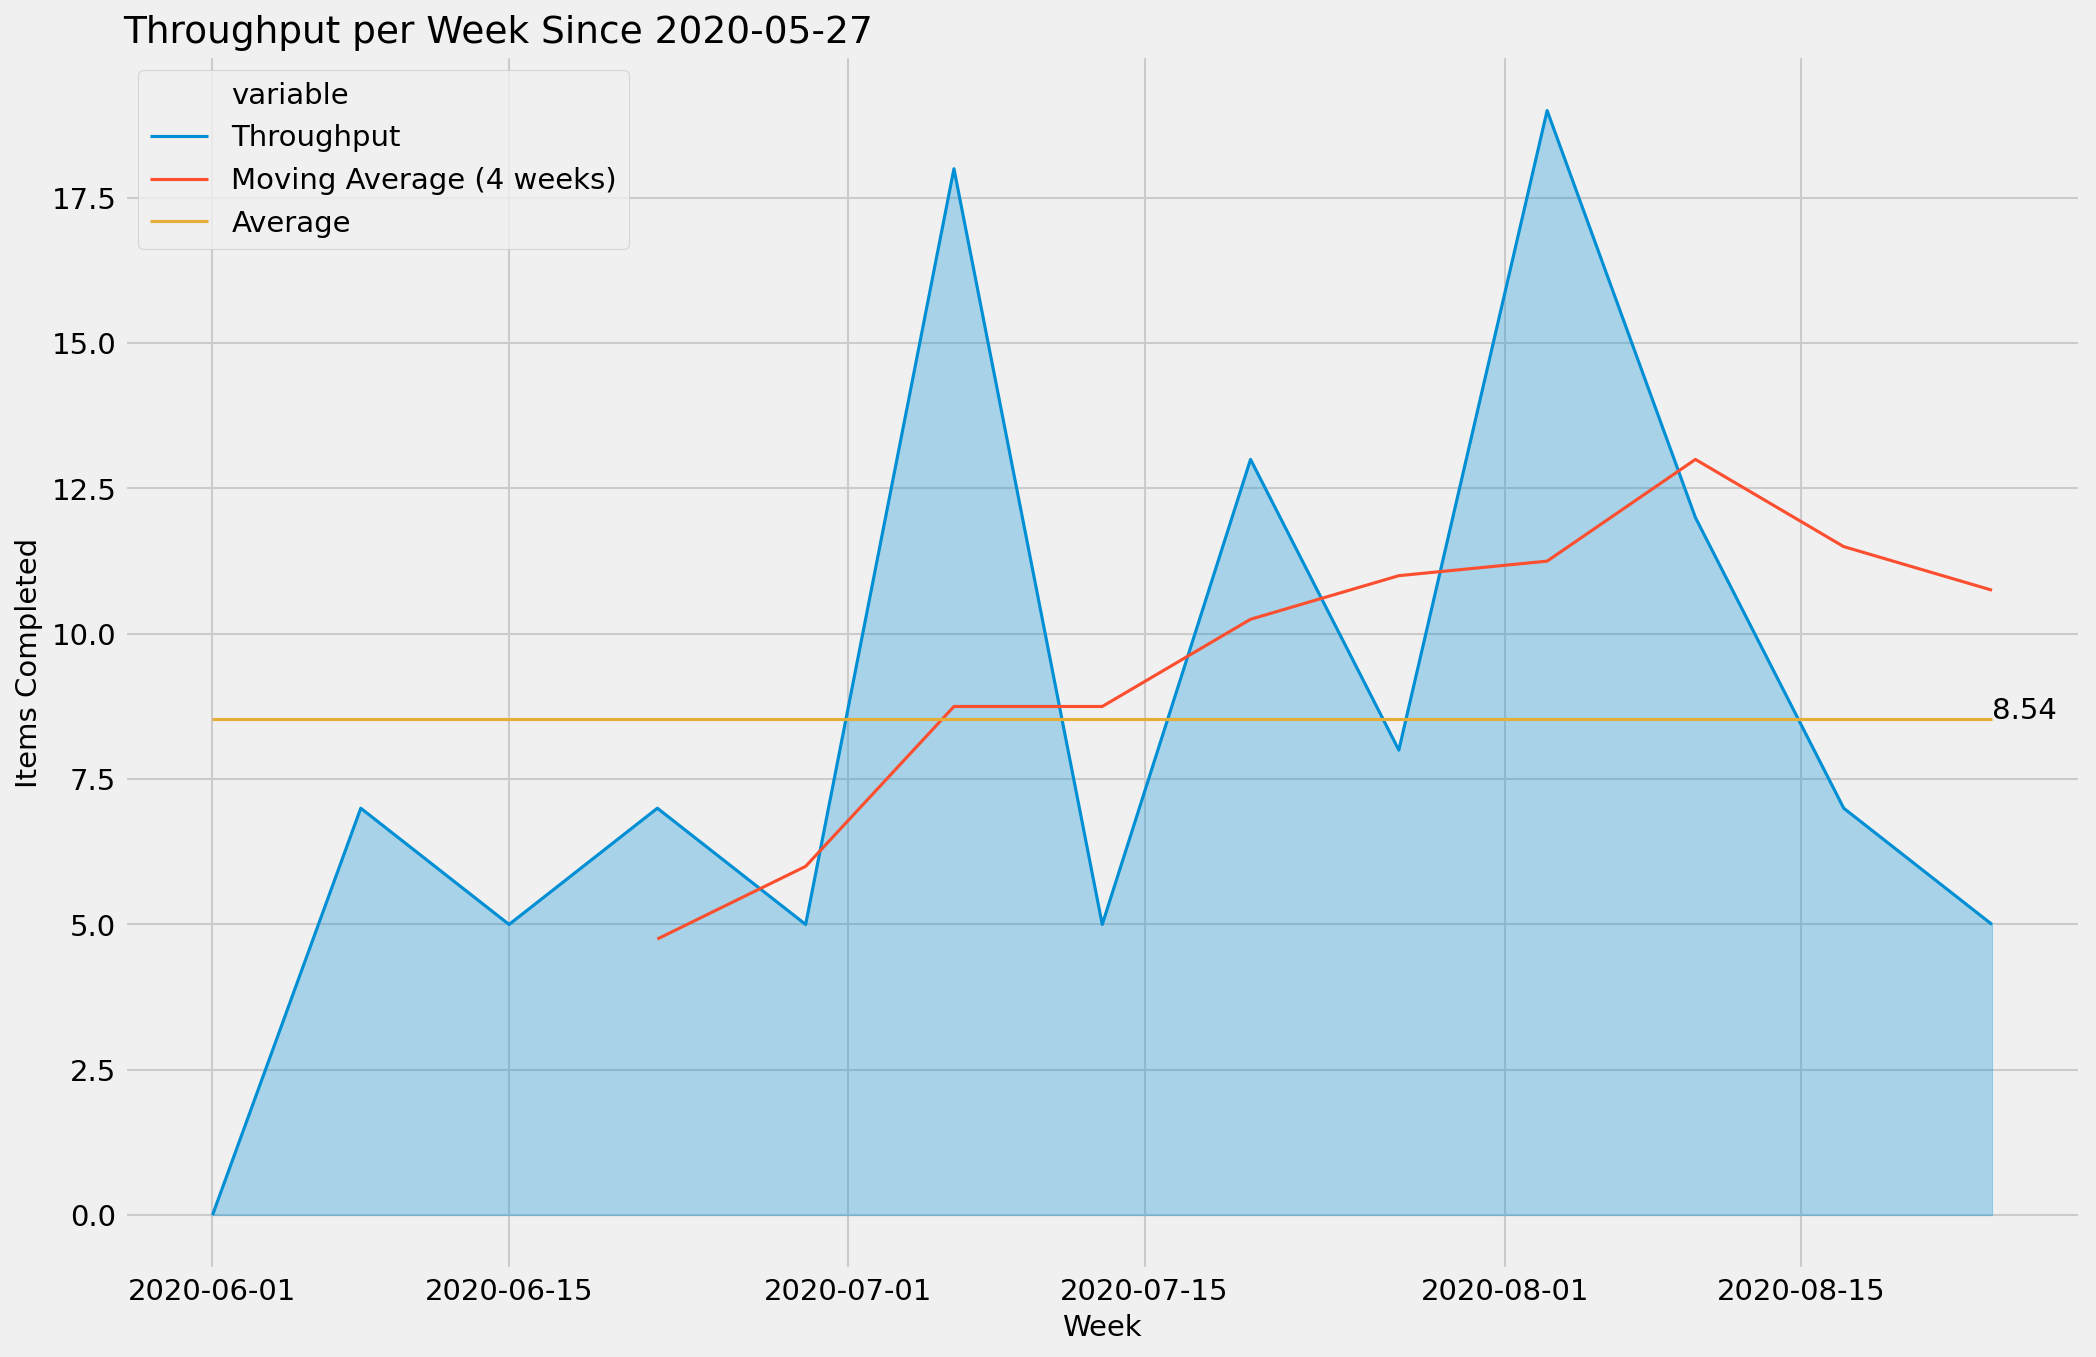

In [14]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

throughput_per_week = throughput_per_week.reset_index()

ax = seaborn.lineplot(x='Date', y='value', hue='variable', data=pandas.melt(throughput_per_week[['Date', 'Throughput', 'Moving Average (4 weeks)', 'Average']], ['Date']))

x = throughput_per_week['Date']
y1 = throughput_per_week['Throughput']
ax.fill_between(x, y1, color='C0', alpha=0.3,
                 interpolate=True)

ax.set_title("Throughput per Week Since {}".format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'normal'})

ax.set_xlabel('Week')
ax.set_ylabel('Items Completed')

_ = ax.text(throughput_per_week['Date'].max(), throughput_per_week['Average'].max(), "{:.2f}".format(throughput_per_week['Average'].max()))

In [15]:
ax.figure.savefig('images/throughput-timeline.png')

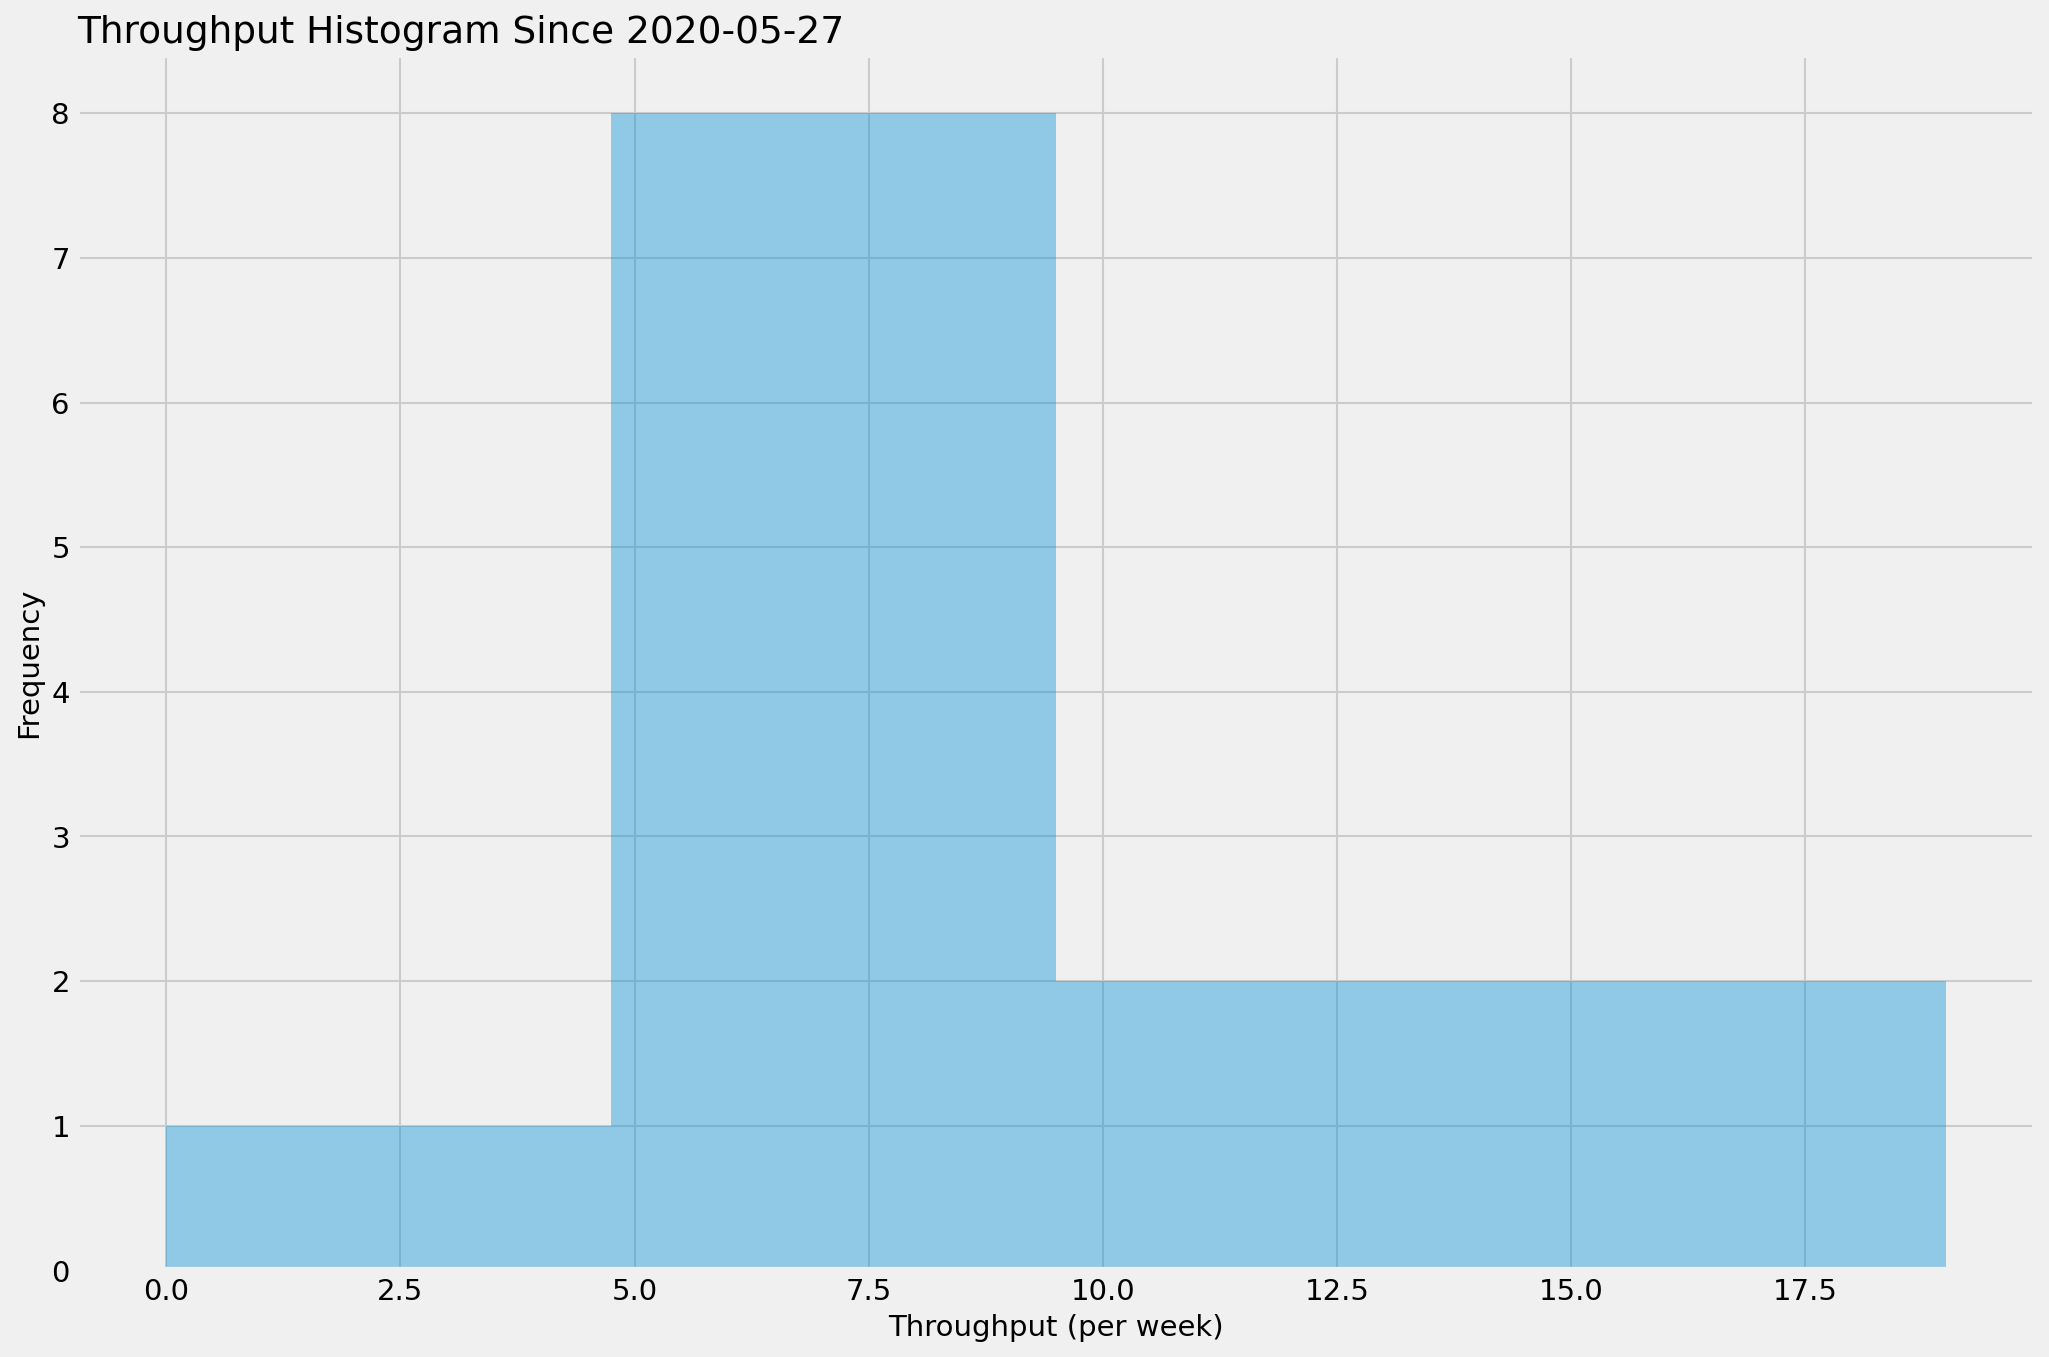

In [16]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.distplot(throughput_per_week['Throughput'], kde=False)

ax.set_title("Throughput Histogram Since {}".format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'normal'})
ax.set_ylabel('Frequency')
_ = ax.set_xlabel('Throughput (per week)')

In [17]:
ax.figure.savefig('images/throughput-histogram.png')

### Cumulative Flow

Understanding the flow of issues in each status is important for understanding where bottlenecks occur.

In [18]:
f = analysis.process_flow_category_data(data, since=FILTER_ISSUES_SINCE, until=FILTER_ISSUES_UNTIL)
f.tail()

,Done,To Do,In Progress
Date,,,
2020-08-20,107,5,25
2020-08-21,107,5,25
2020-08-22,107,5,25
2020-08-23,107,5,25
2020-08-24,111,4,22


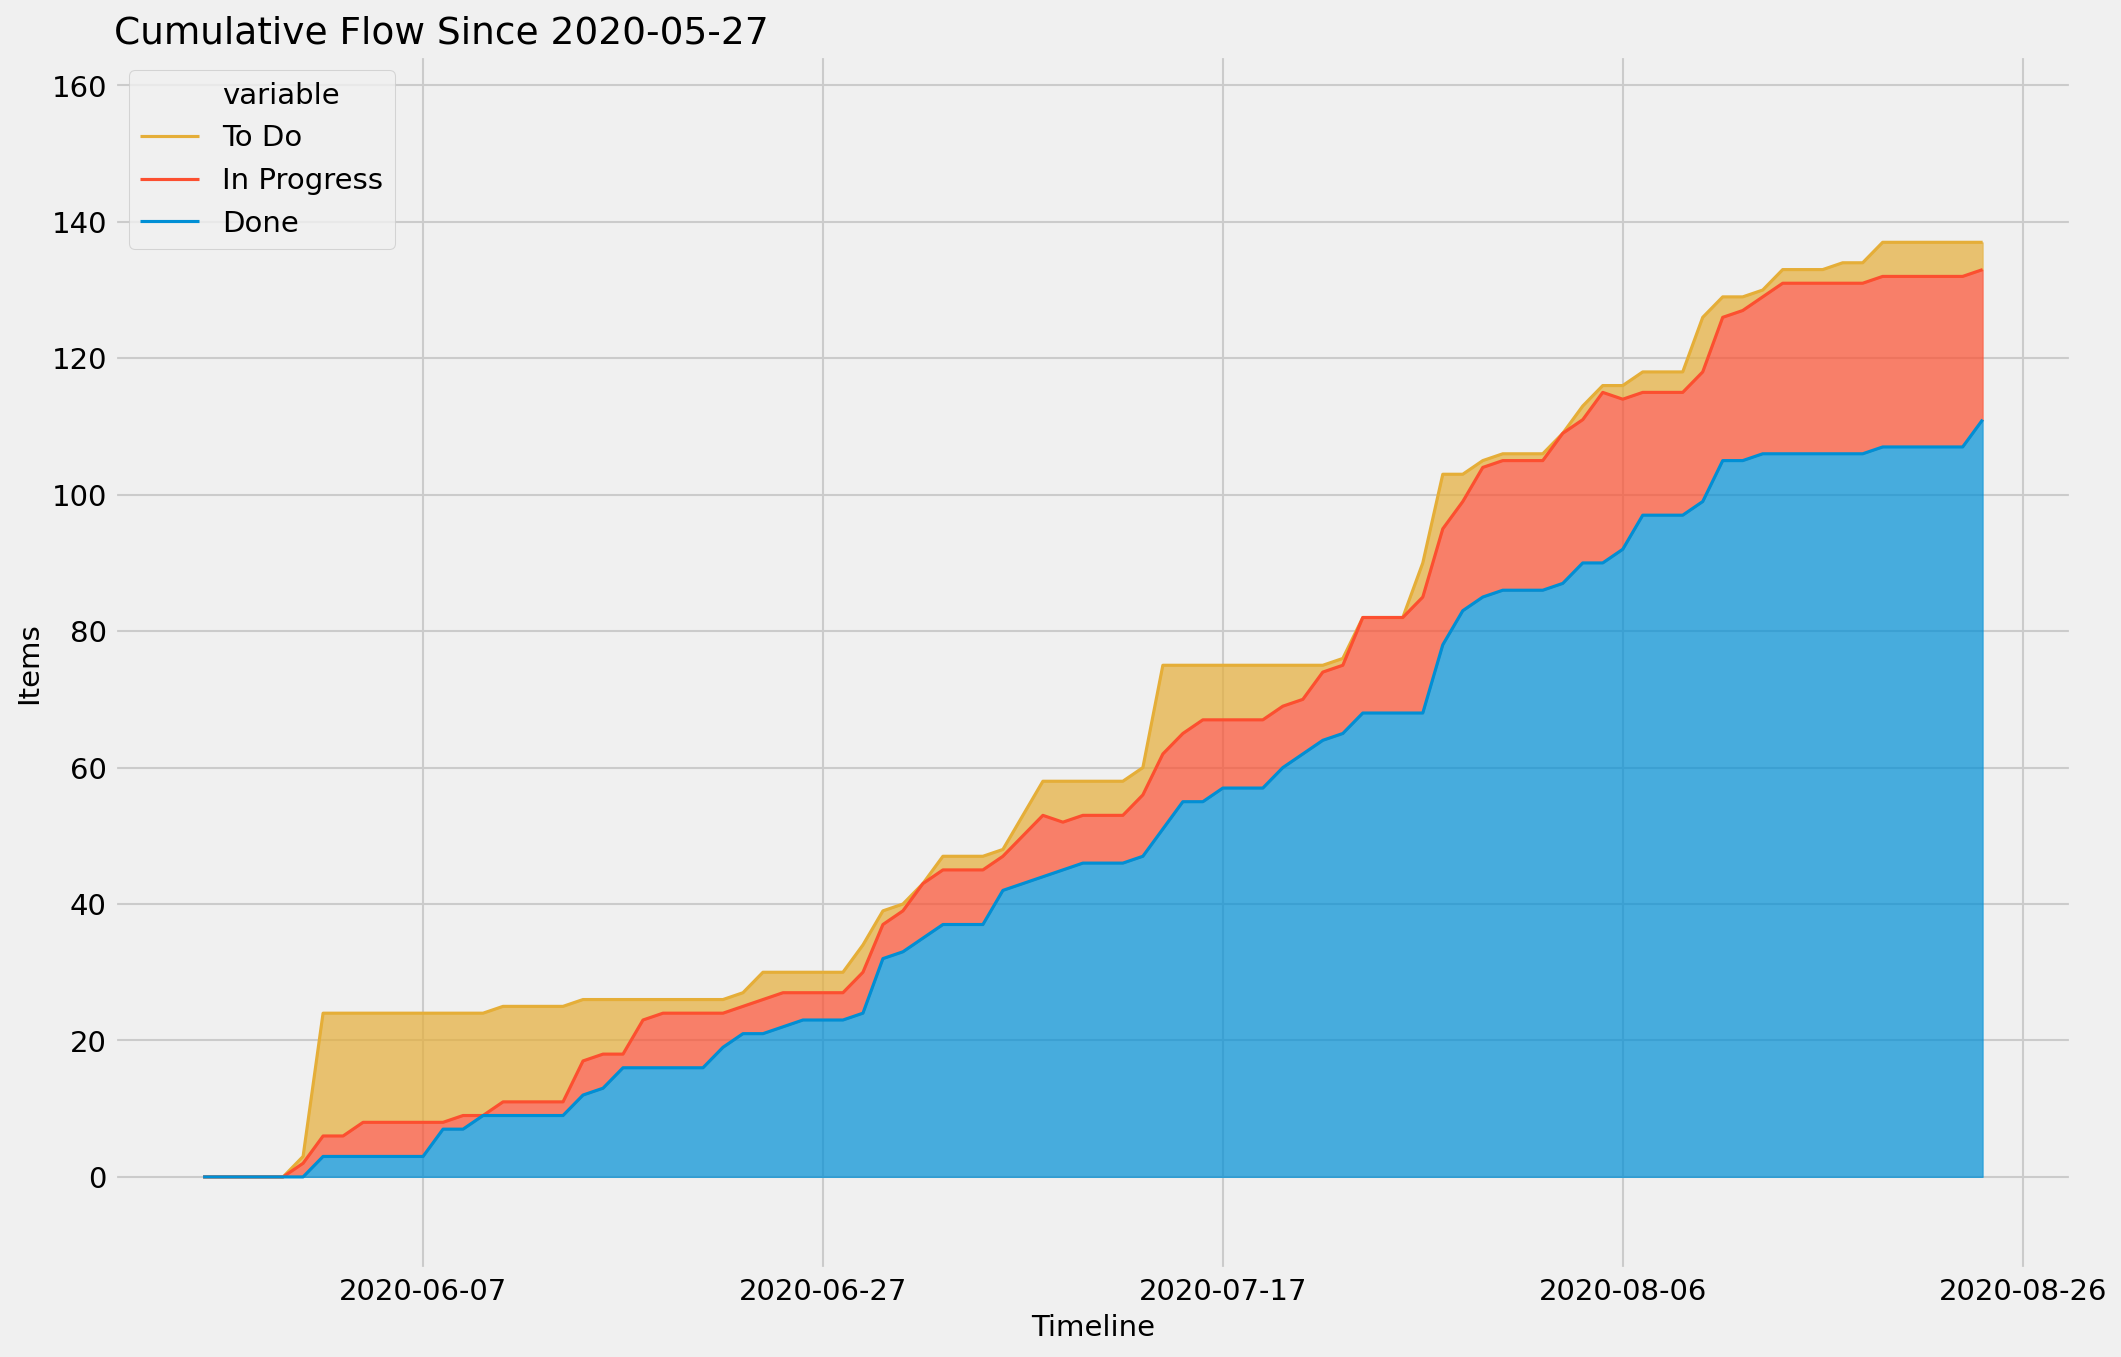

In [19]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))
ax = analysis.plot_flow(f, status_columns=('Done', 'In Progress', 'To Do'))

In [20]:
ax.figure.savefig('images/flow-category-timeline.png')

In [21]:
f = analysis.process_flow_data(data, since=FILTER_ISSUES_SINCE, until=FILTER_ISSUES_UNTIL)
f.tail()

,Can't Fix,Review,Accepted,Backlog,Prioritized,Deployed,To Do,In Progress
Date,,,,,,,,
2020-08-20,13,8,9,0,28,94,1,11
2020-08-21,13,8,9,0,28,94,1,11
2020-08-22,13,8,9,0,28,94,1,11
2020-08-23,13,8,9,0,28,94,1,11
2020-08-24,13,5,9,0,28,98,0,11


<AxesSubplot:title={'left':'Cumulative Flow Since 2020-05-27'}, xlabel='Timeline', ylabel='Items'>

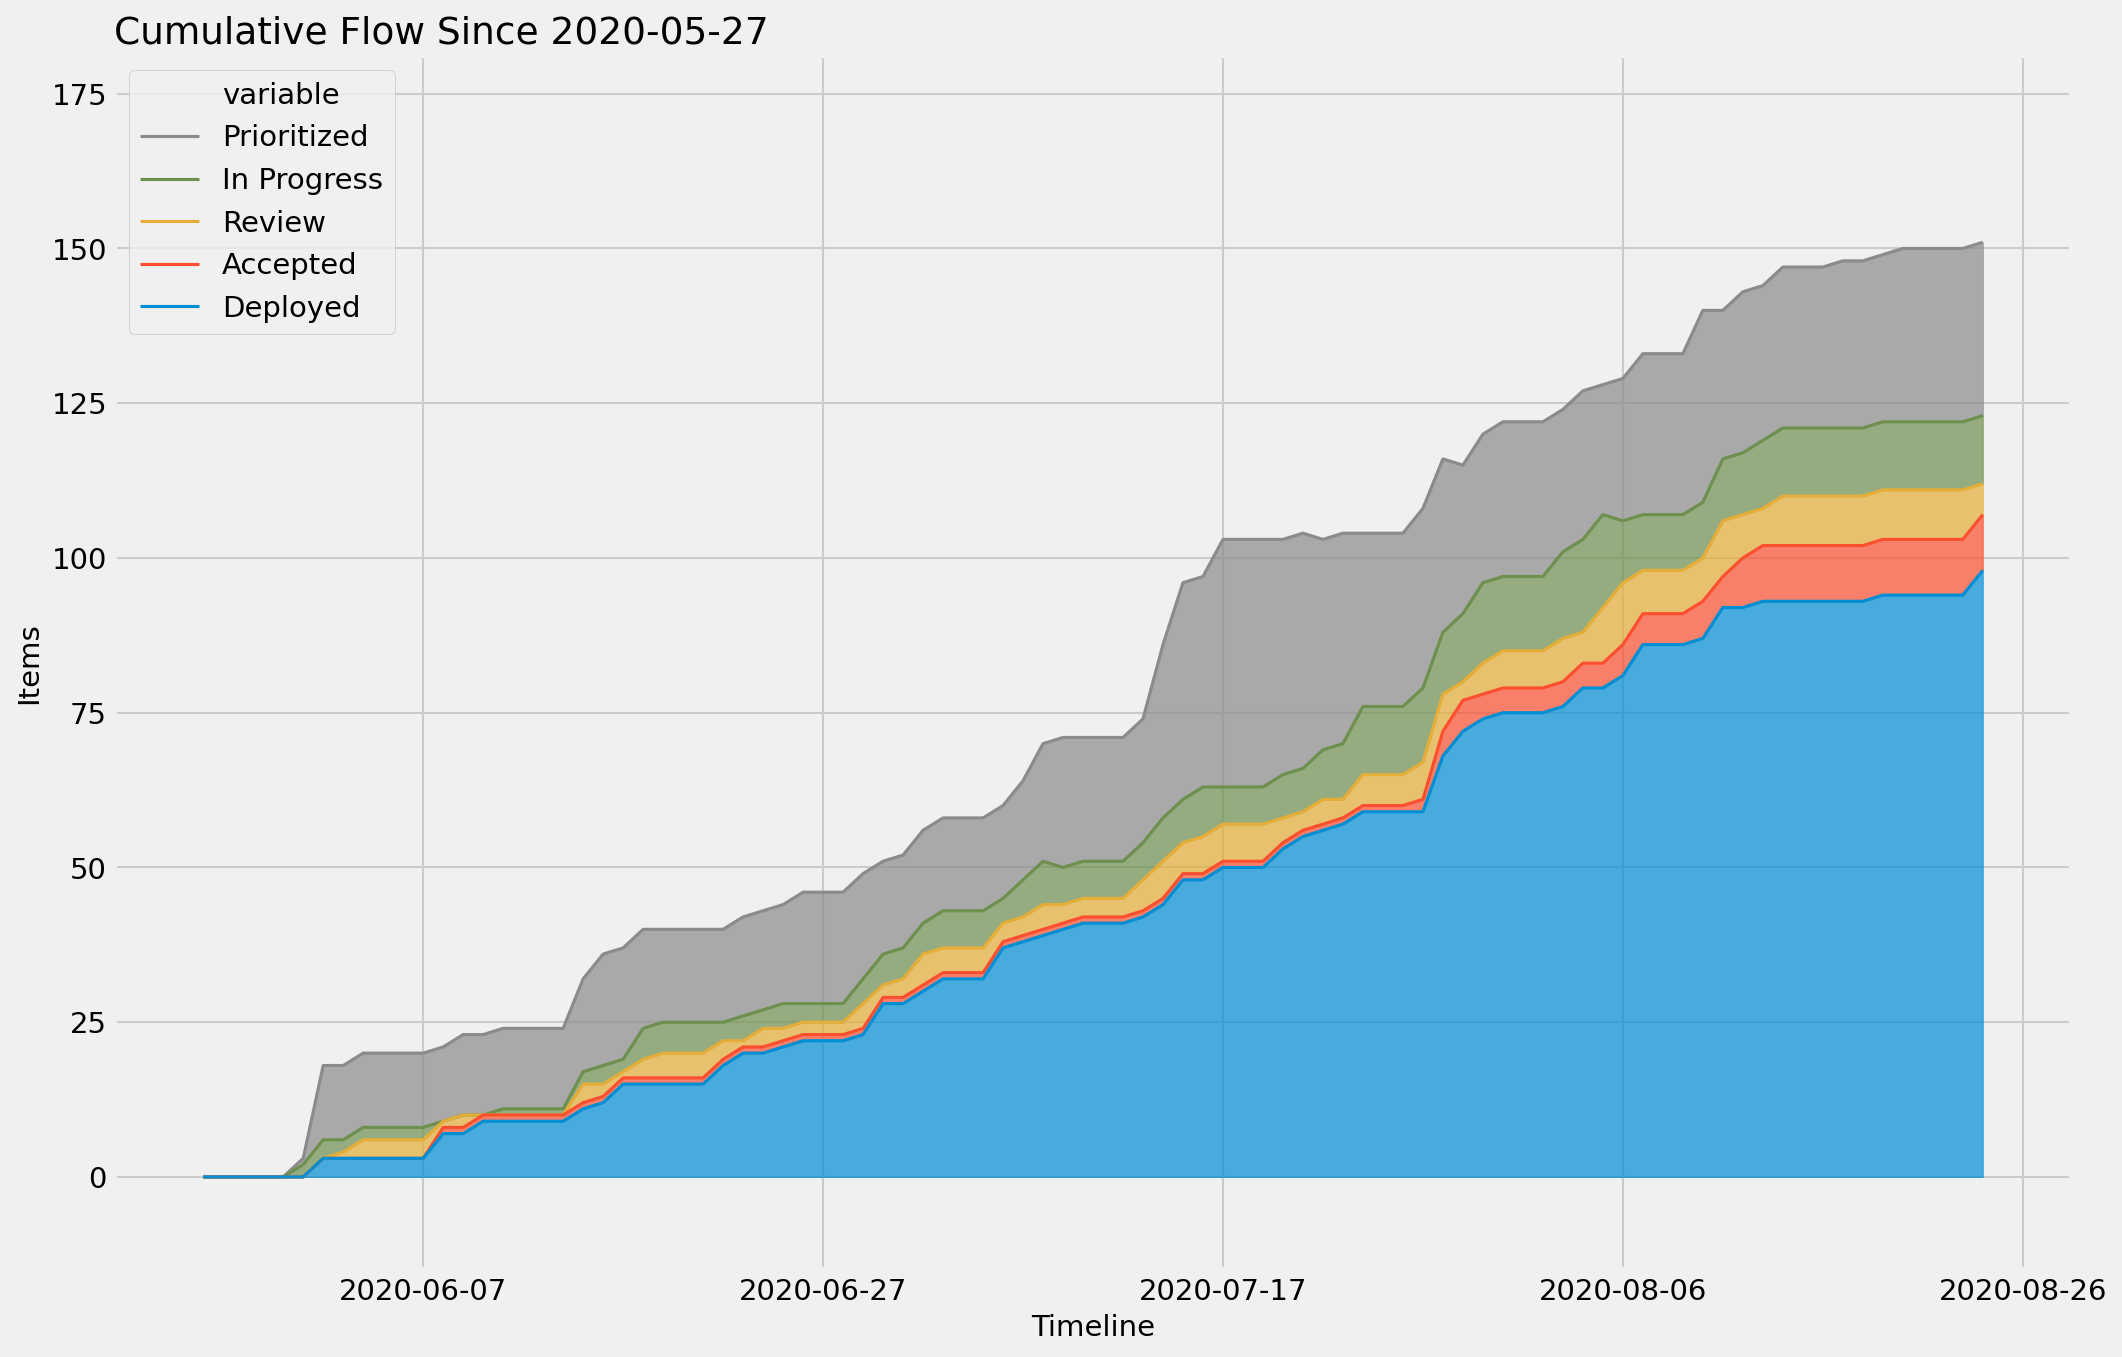

In [22]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))
analysis.plot_flow(f, status_columns=list(s for s in reversed(STATUS_ORDER) if s in f))

In [23]:
ax.figure.savefig('images/flow-timeline.png')

<AxesSubplot:title={'left':'Cumulative Flow Since 2020-05-27'}, xlabel='Timeline', ylabel='Items'>

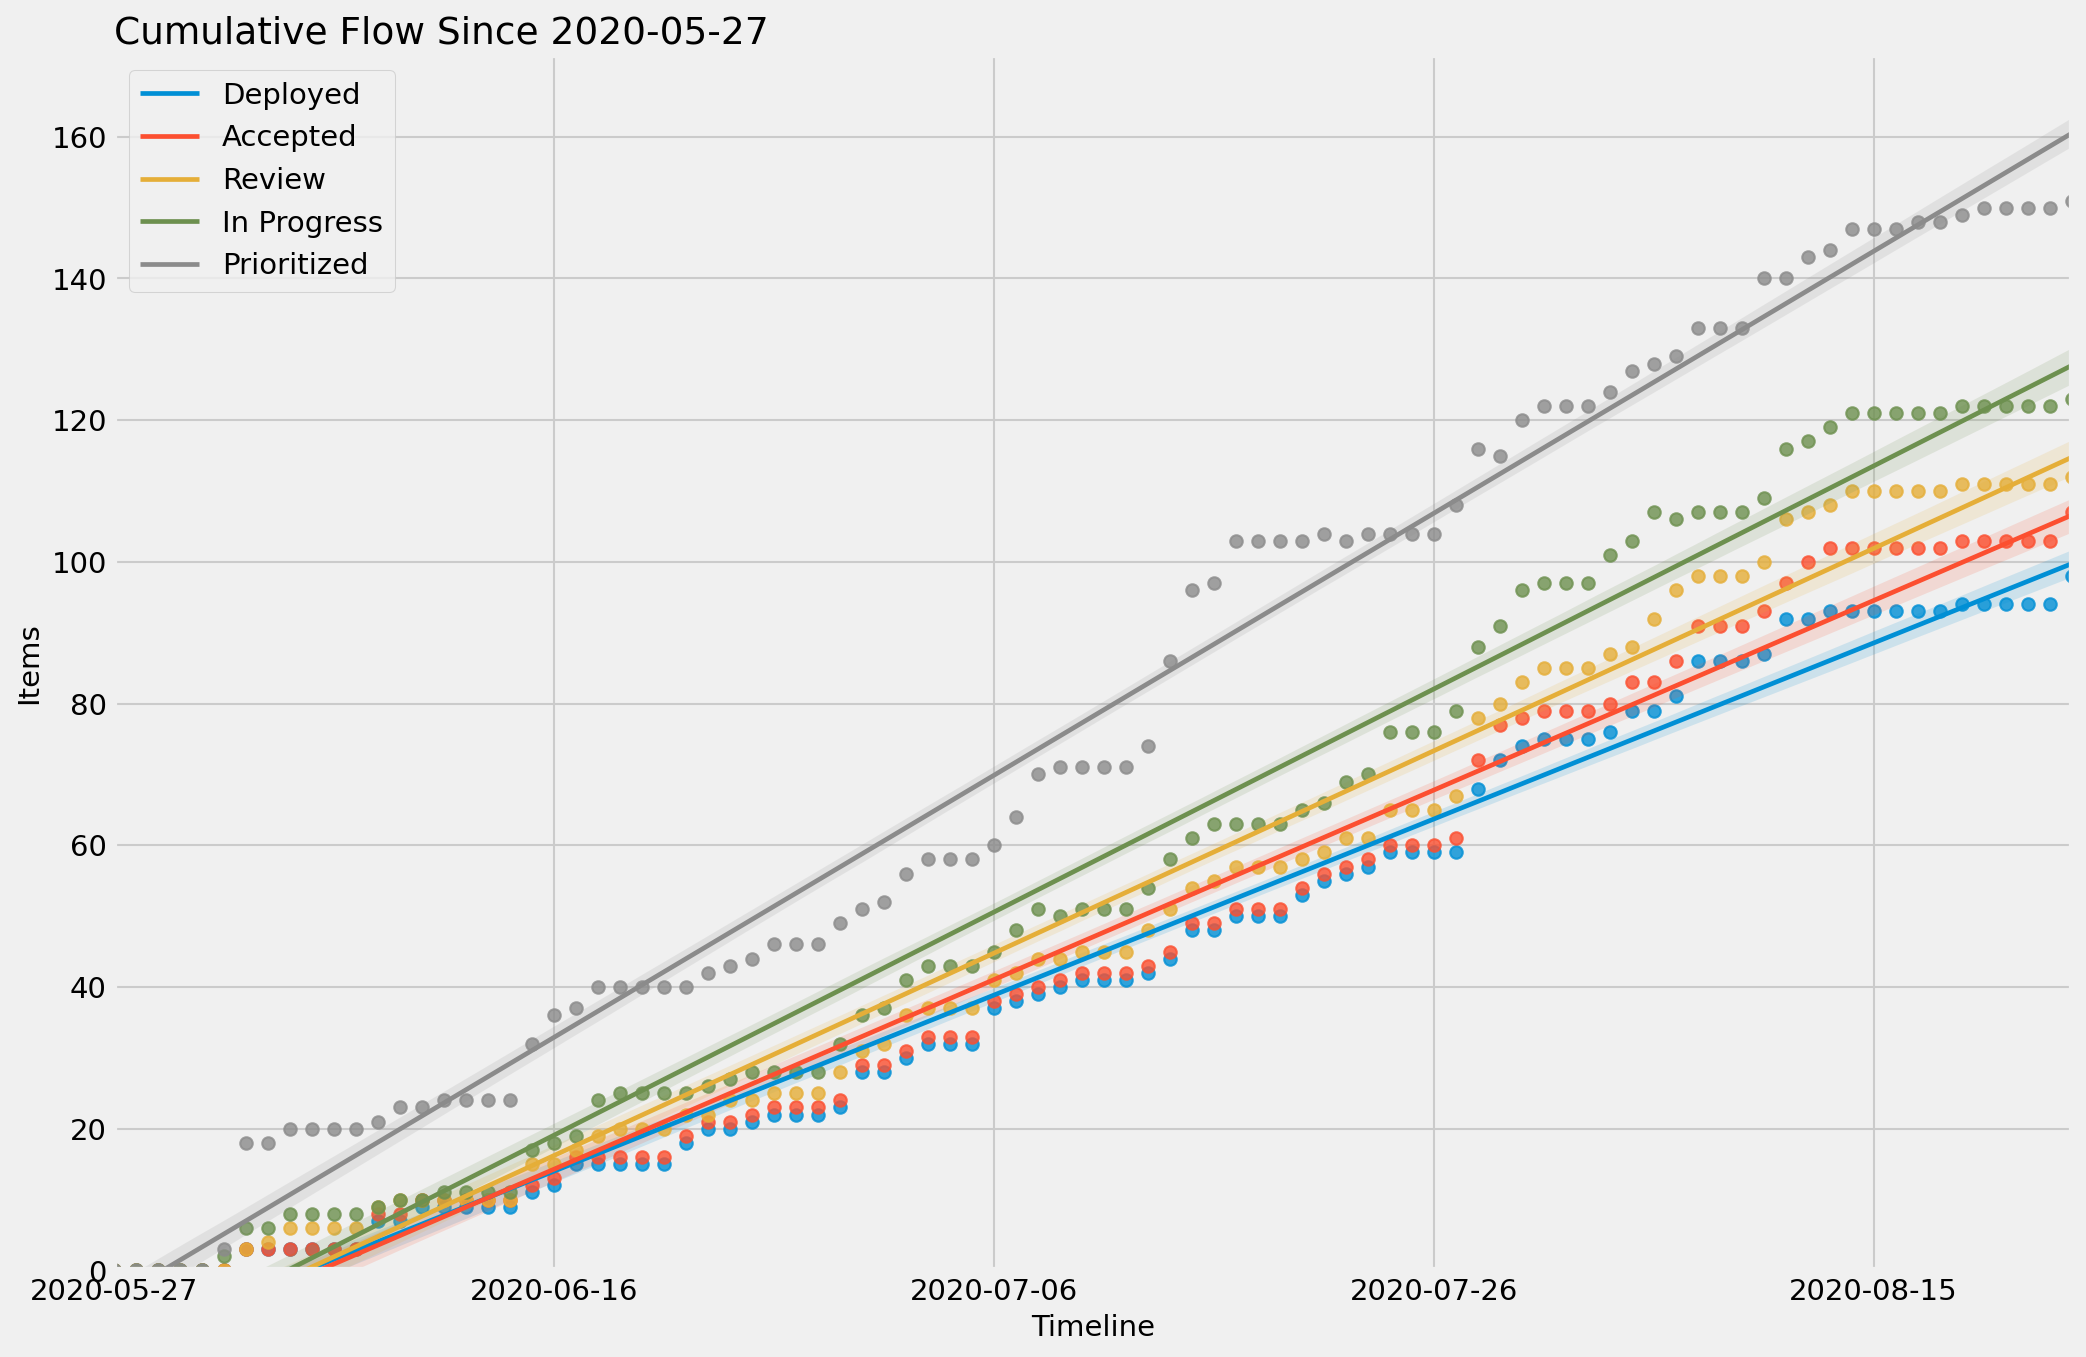

In [54]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))
analysis.plot_flow_trendlines(f, status_columns=list(s for s in reversed(STATUS_ORDER) if s in f))

In [51]:
ax.figure.savefig('images/flow-timeline-trend.png')

### Work In Progress

We should also keep track of how much work in progress we have at any point in time.

In [25]:
wip, _ = analysis.process_wip_data(issue_data, since=FILTER_ISSUES_SINCE, until=FILTER_ISSUES_UNTIL)
wip.tail()

,Work In Progress,Moving Average (10 days),Moving Standard Deviation (10 days),Average,Standard Deviation
Date,,,,,
2020-08-20,22,21.3,1.702939,9.288889,7.068278
2020-08-21,22,21.7,1.251666,9.288889,7.068278
2020-08-22,22,22.0,0.816497,9.288889,7.068278
2020-08-23,22,22.2,0.421637,9.288889,7.068278
2020-08-24,19,21.9,1.100505,9.288889,7.068278


Text(0, 0.5, 'Items')

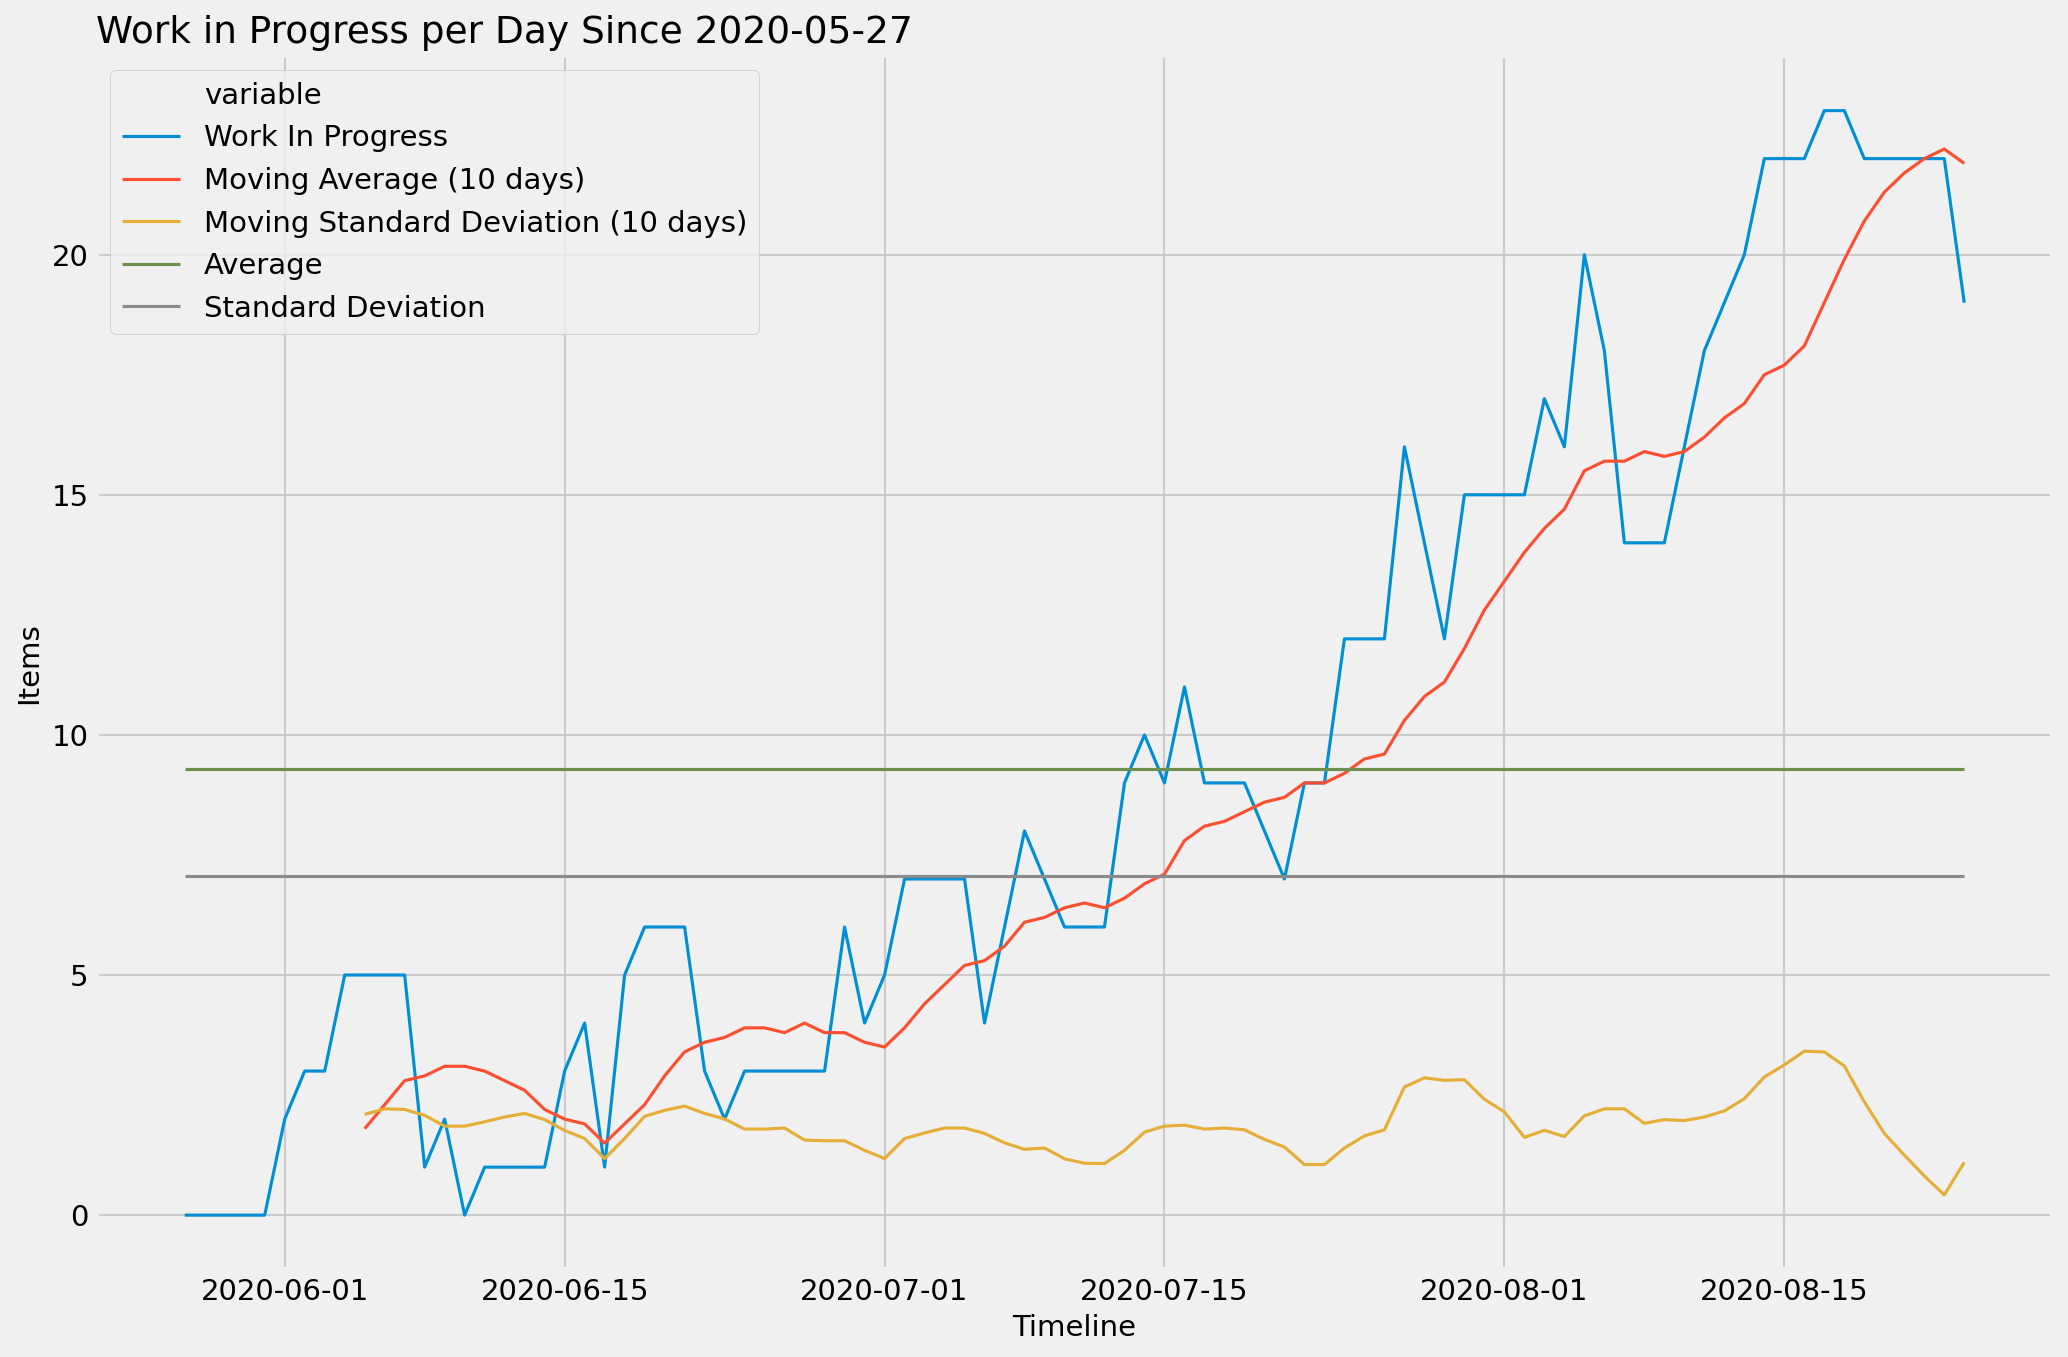

In [26]:
# melt the data to be able to be sent to lineplot
wip = wip.reset_index()
wip_melted = pandas.melt(wip, ['Date'])
wip_melted['value'] = wip_melted['value'].astype(float)

matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.lineplot(x='Date', y='value', hue='variable', data=wip_melted)

ax.set_title(f"Work in Progress per Day Since {wip['Date'].min().strftime('%Y-%m-%d')}", loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'normal'})

ax.set_xlabel('Timeline')
ax.set_ylabel('Items')

In [27]:
ax.figure.savefig('images/wip-timeline.png')

We should know how much work in progress we currently have and its ages.

In [28]:
age_data = analysis.process_wip_age_data(issue_data, since=FILTER_ISSUES_SINCE, until=FILTER_ISSUES_UNTIL)

Text(0, 0.5, 'Days')

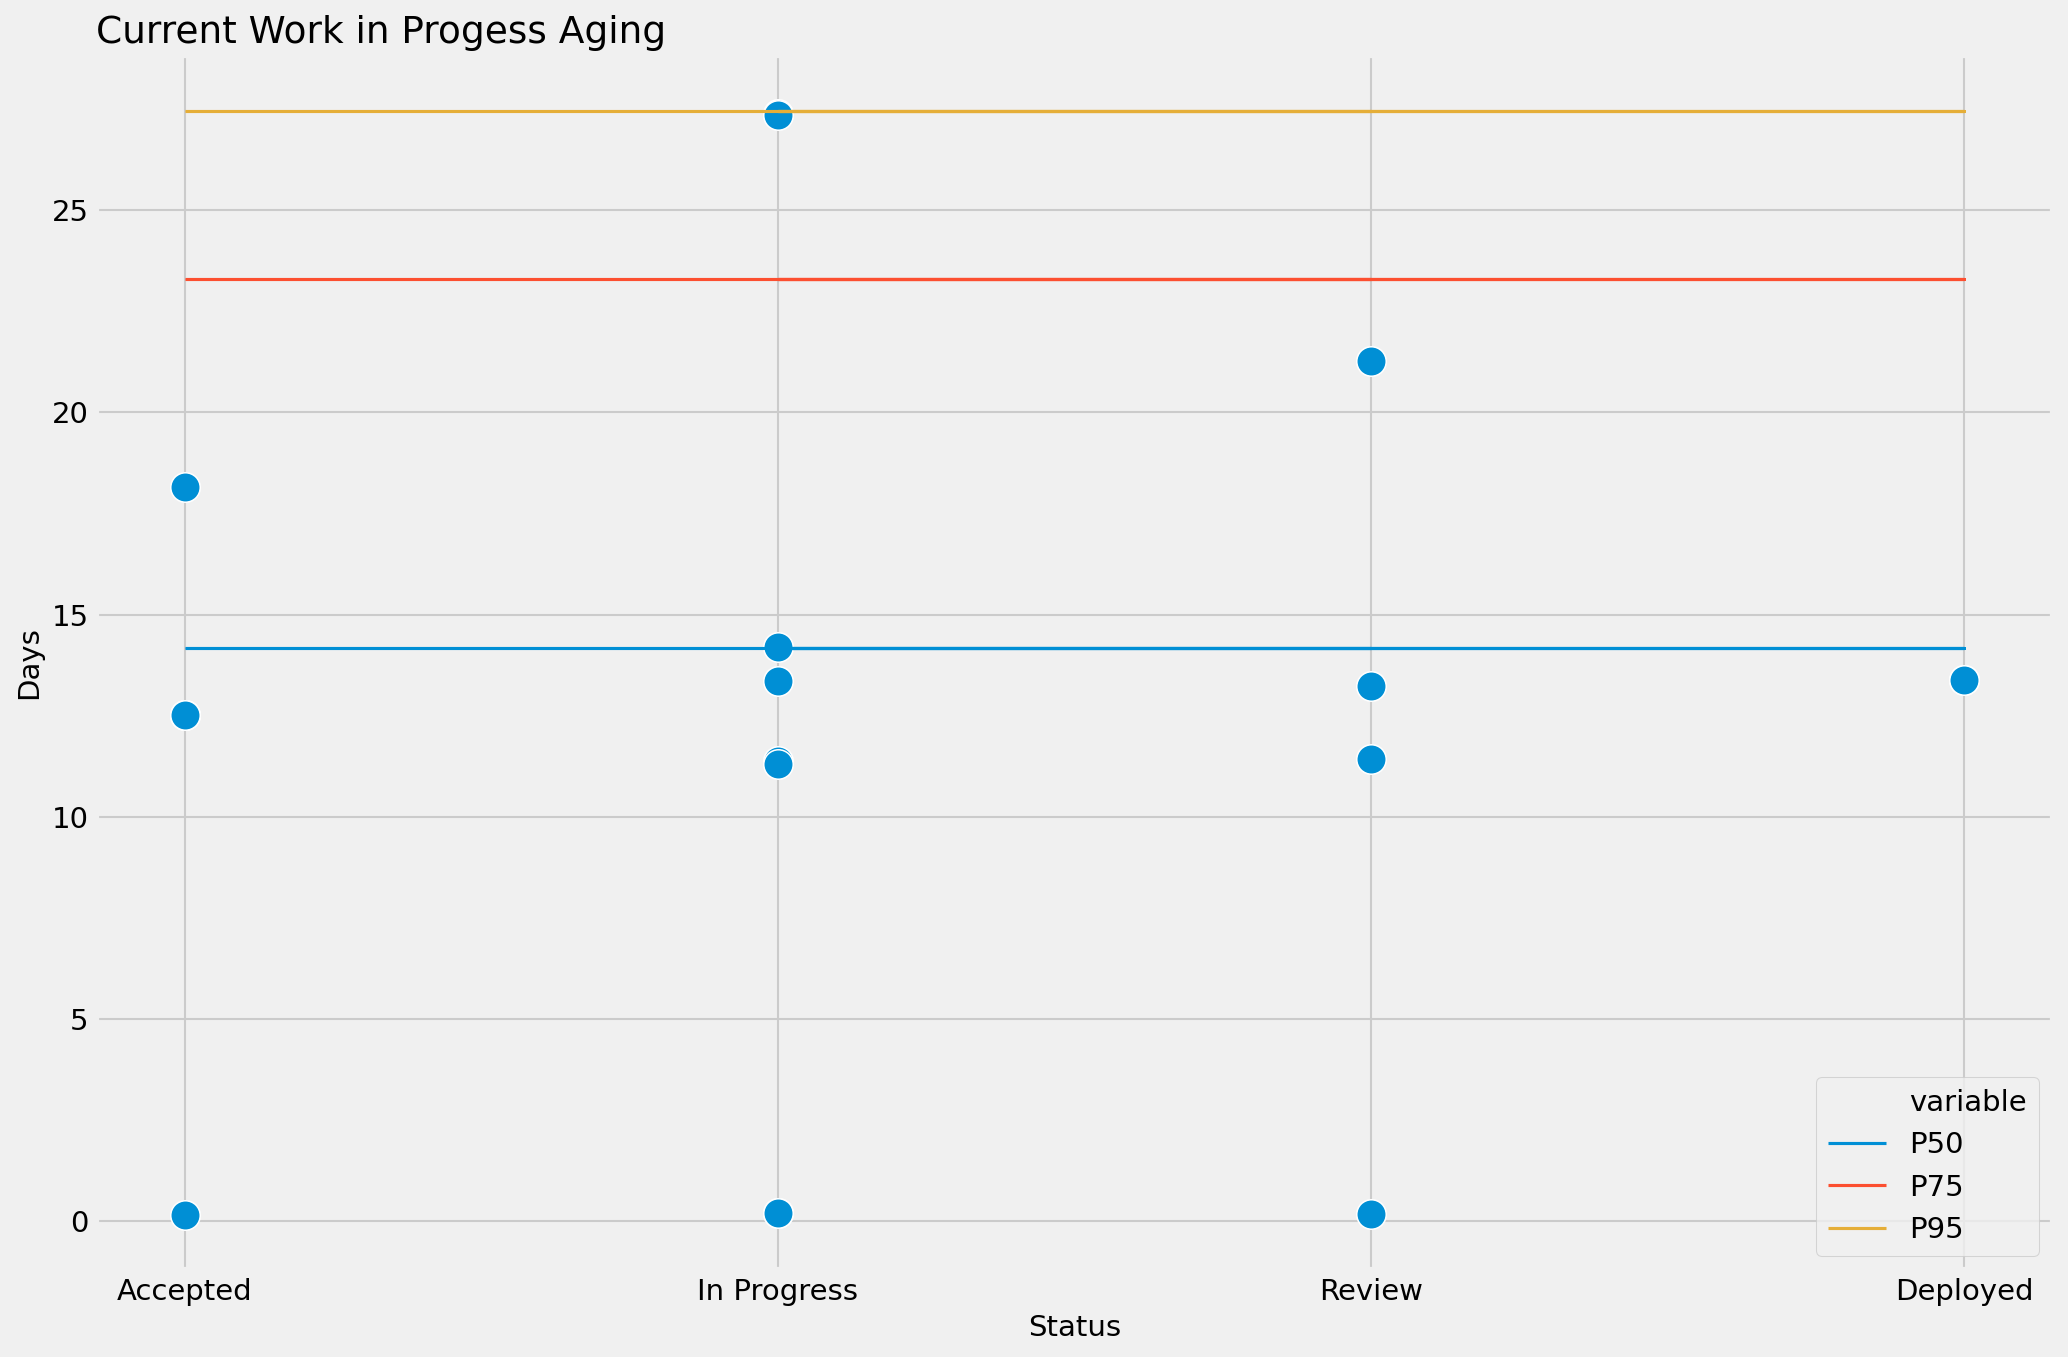

In [29]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = seaborn.scatterplot(x='last_issue_status', y='Age in Stage', data=age_data, s=200, sizes=(200, 200))

ax = seaborn.lineplot(x='last_issue_status', y='value', hue='variable', dashes=True, data=pandas.melt(age_data[['last_issue_status', 'P50', 'P75', 'P95']], ['last_issue_status']), ax=ax)

ax.set_title("Current Work in Progess Aging", loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'normal'})

ax.set_xlabel('Status')
ax.set_ylabel('Days')

In [30]:
ax.figure.savefig('images/wip-aging.png')

---

## Forecasting

Welcome to the main event. Let's try to forecast the future completion of issues based on the historical distribution of throughput.

### Kaplan-Meier Surviability

To forecast the probability of completion for a single issue, we can use our historical cycle time data and fit it into a Kaplan-Meier survivability curve.

This model will allow us to forecast the probability of a single issue having a cycle time longer than a particular value (i.e., surviving past a point in time):

In [31]:
model, km = analysis.analyze_survival_km(issue_data, since=FILTER_ISSUES_SINCE, until=FILTER_ISSUES_UNTIL)

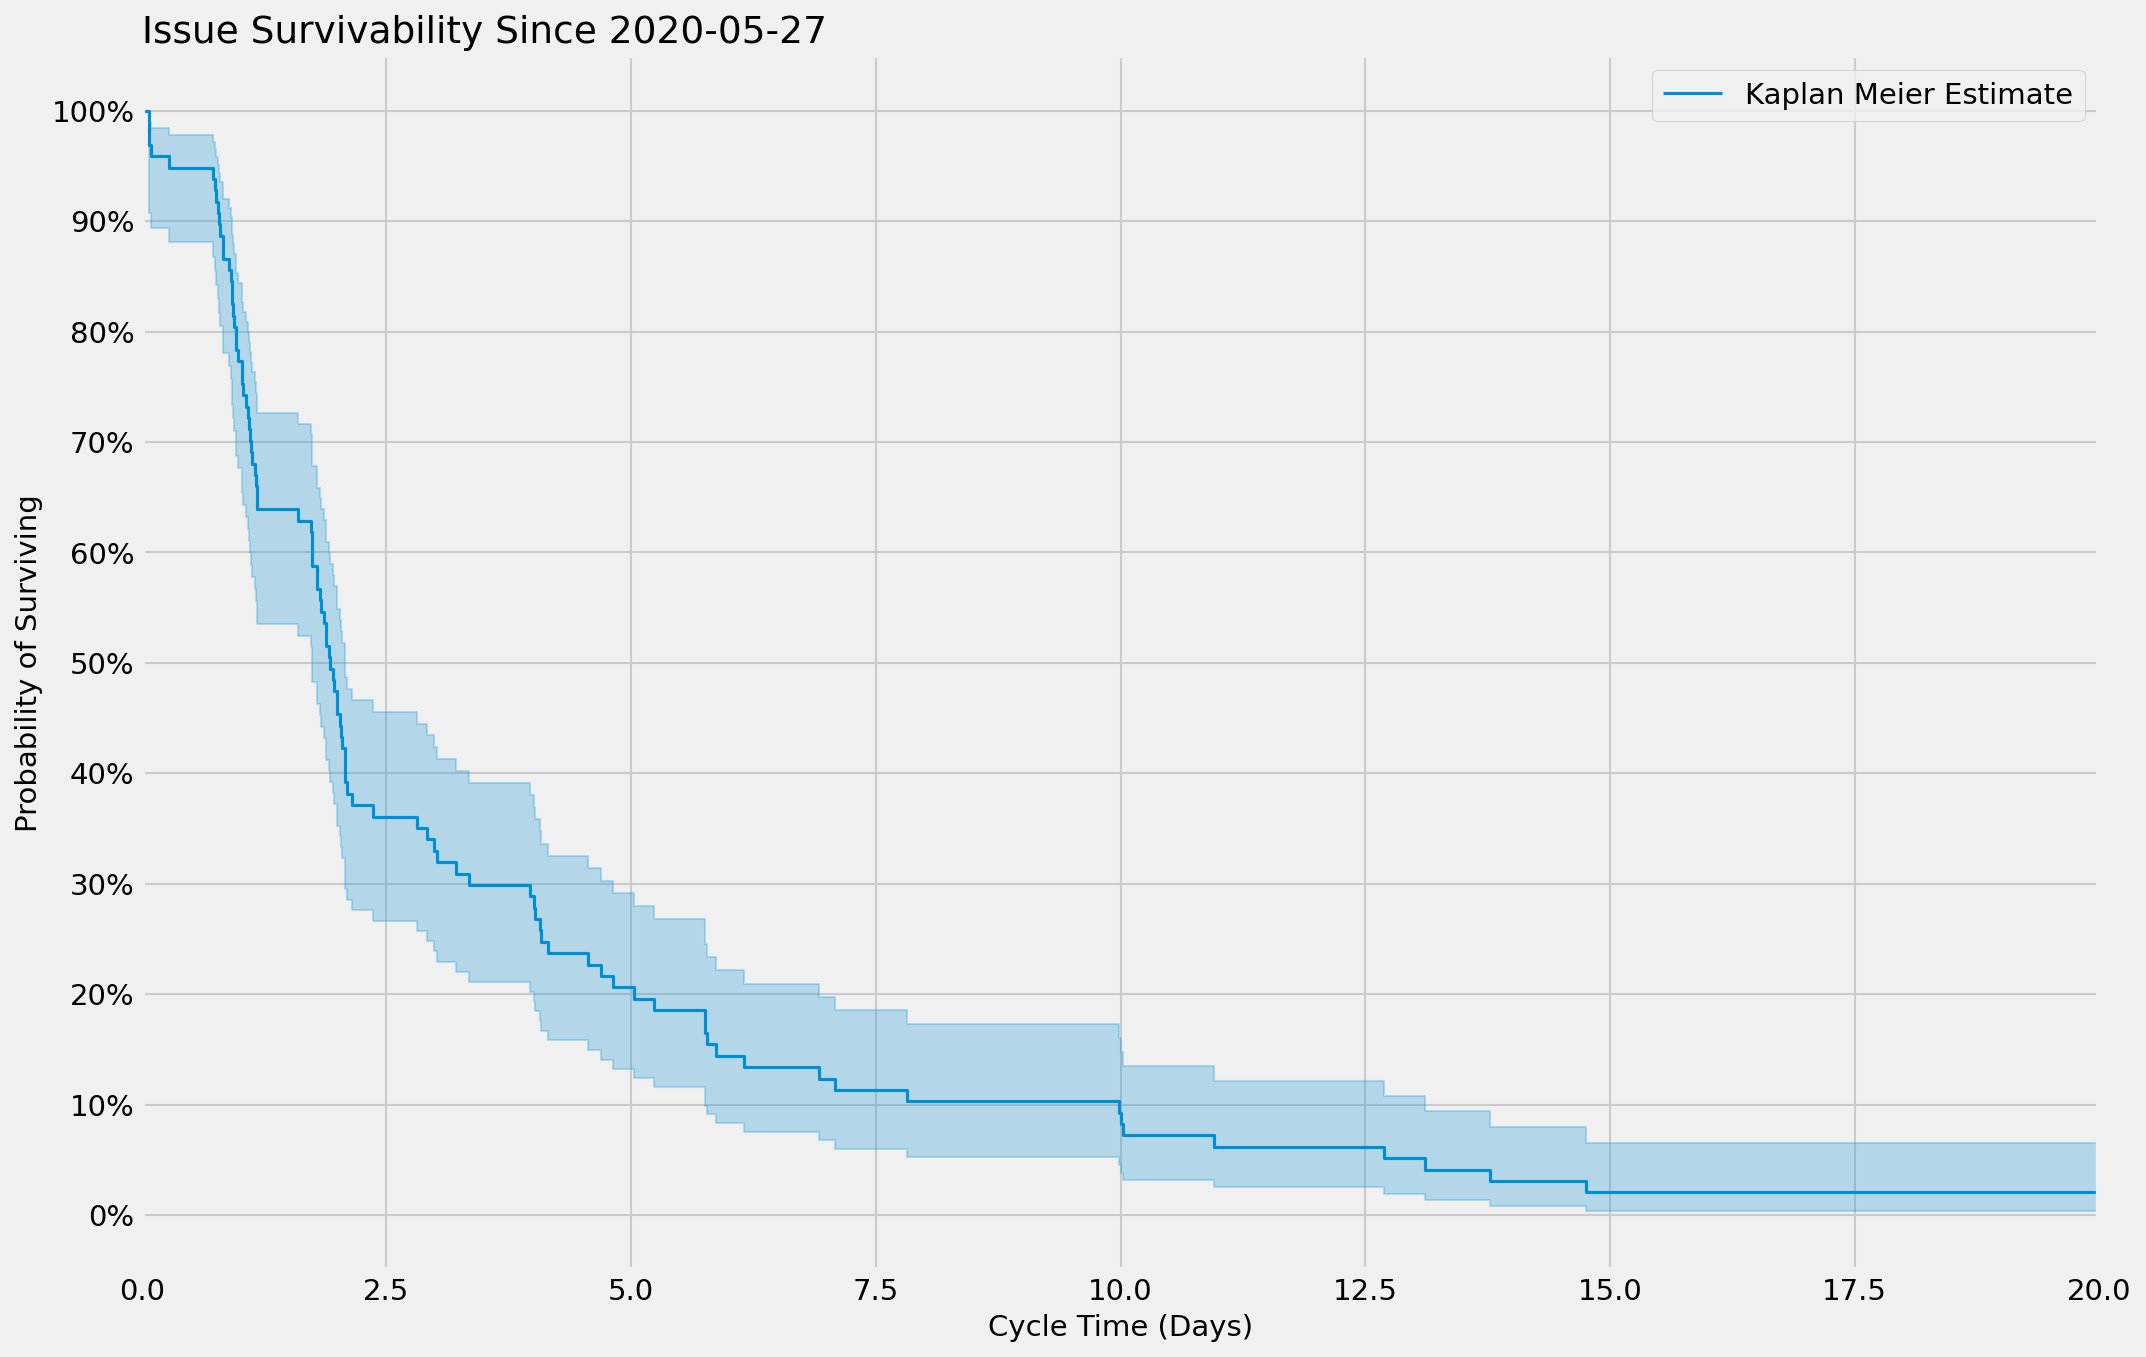

In [32]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = km.plot()

ax.set_title('Issue Survivability Since {}'.format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'normal'})
ax.set_yticks([i/100.0 for i in range(0,110,10)])
def format_func(value, tick_number):
    return '{}%'.format(int(value*100))
ax.set_xlim([0, 20])
ax.yaxis.set_major_formatter(matplotlib.pyplot.FuncFormatter(format_func))
ax.set_ylabel('Probability of Surviving')
_ = ax.set_xlabel('Cycle Time (Days)')

In [33]:
ax.figure.savefig('images/forecast-kaplan-meier.png')

*How do you read this graph?*

> The probability of an issue having a cycle time > 10 days (i.e., surviving past 10 days) is near 10%.

### Weibull Analysis

We can also use the survivability data and fit it to a Weibull distribution. This will allow us to determine some reliability characteristics and trends of the population based on the sample.

In [34]:
model, wb = analysis.analyze_survival_wb(issue_data, since=FILTER_ISSUES_SINCE, until=FILTER_ISSUES_UNTIL)

Text(0.5, 0, 'Cycle Time (Days)')

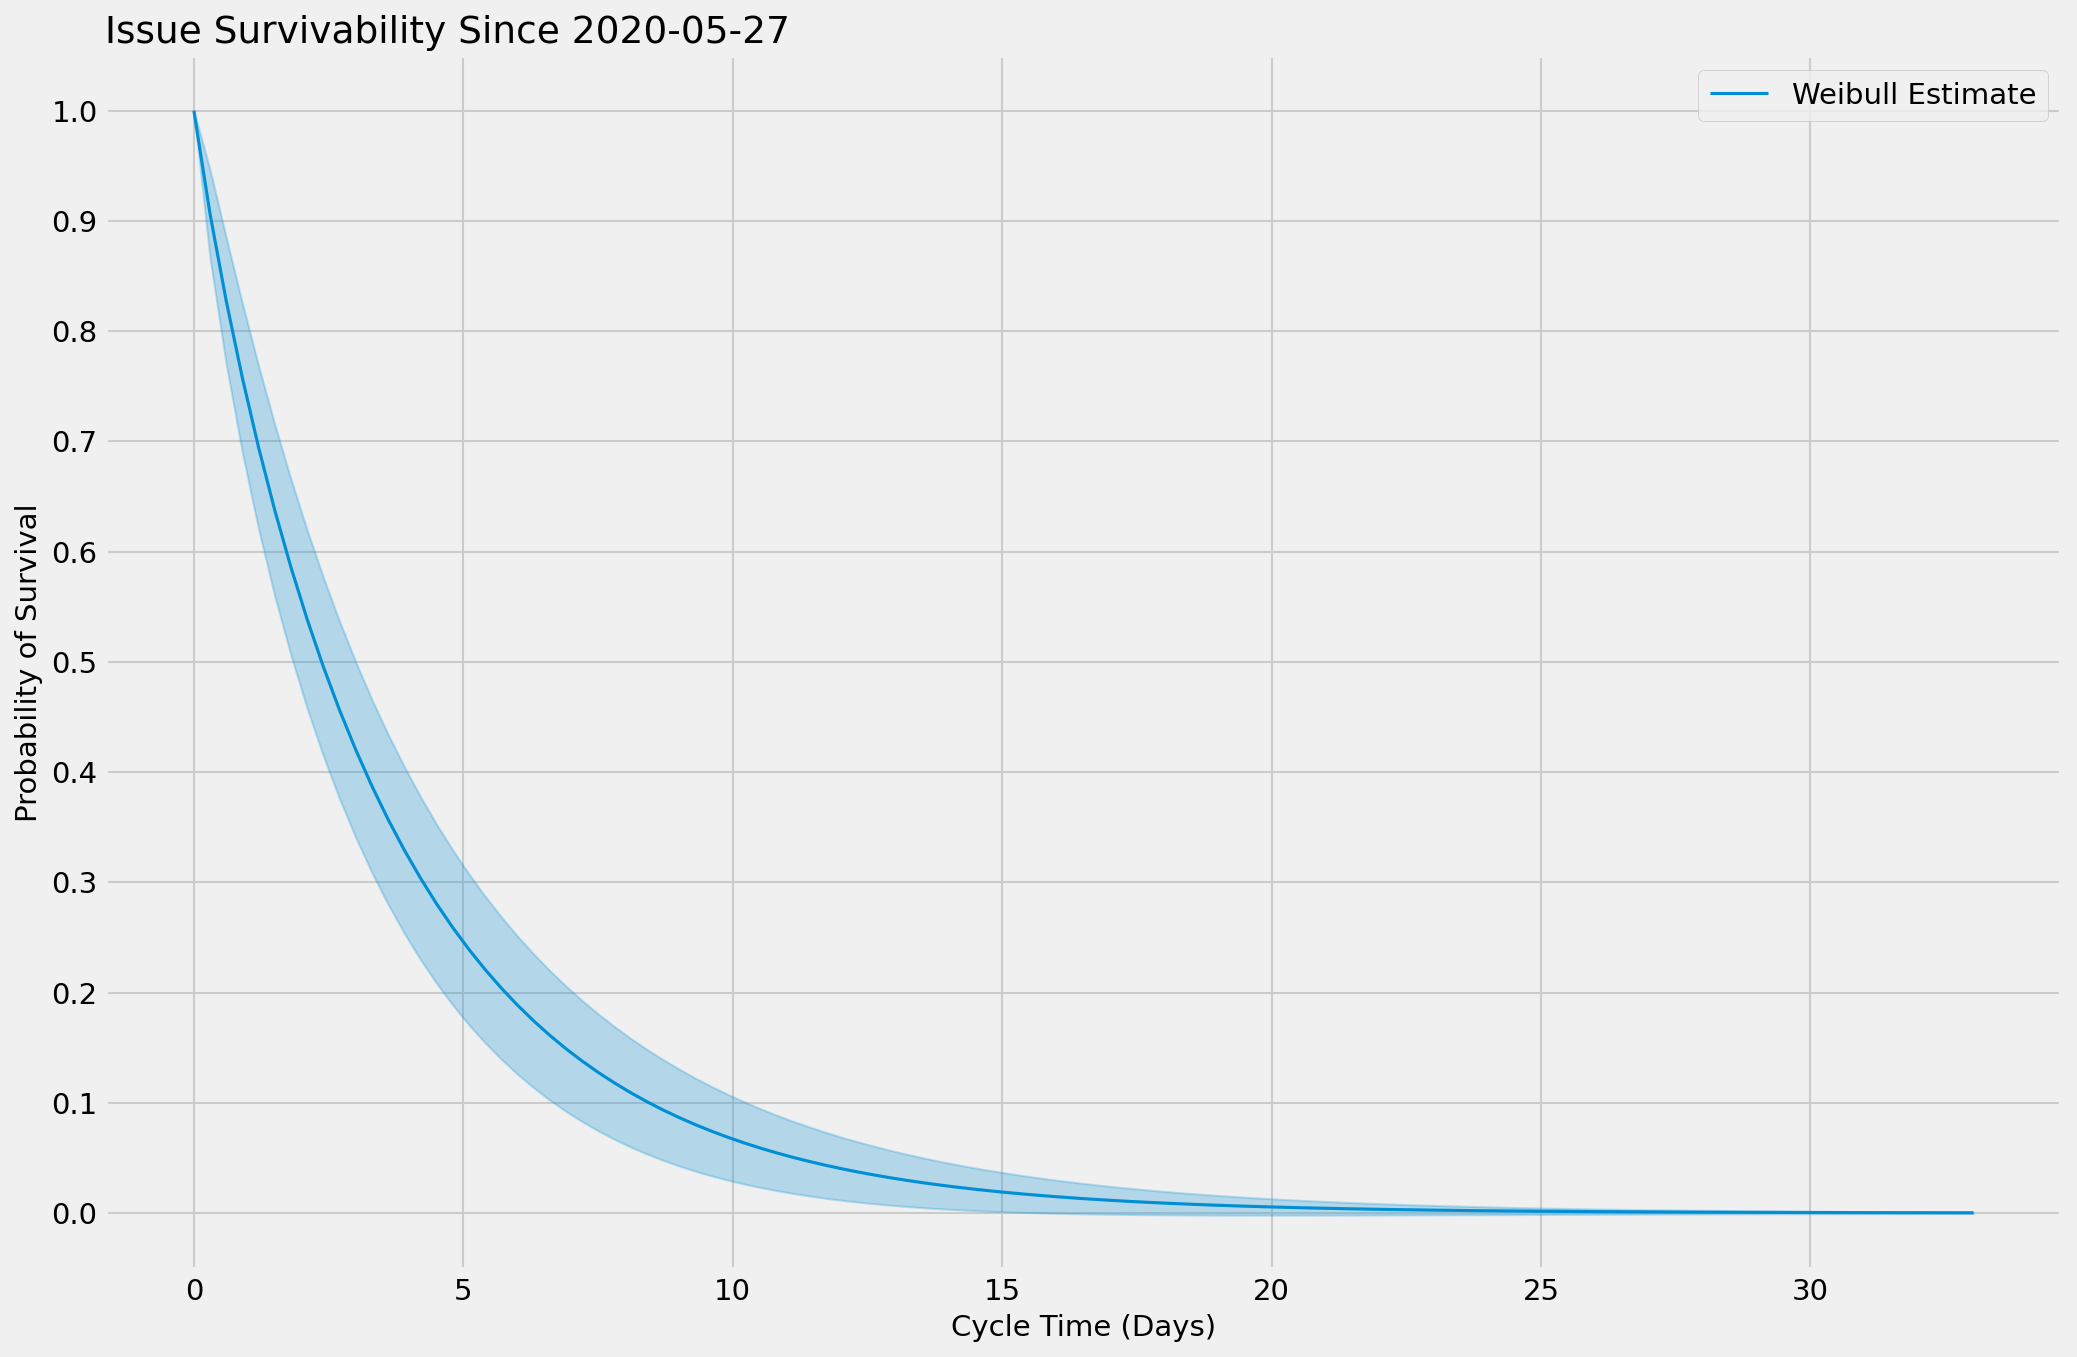

In [35]:
matplotlib.pyplot.figure(dpi=150, figsize=(15,10))

ax = wb.plot_survival_function()
ax.set_yticks([i/100.0 for i in range(0,110,10)])
ax.set_title('Issue Survivability Since {}'.format(FILTER_ISSUES_SINCE), loc='left', fontdict={
             'fontsize': 18, 'fontweight': 'normal'})
ax.set_ylabel('Probability of Survival')
ax.set_xlabel('Cycle Time (Days)')

In [36]:
ax.figure.savefig('images/forecast-weibull-survival.png')

### Monte Carlo Simulation

So, what if you want to have a prediction of many issues over time (say, for instance, a batch of issues in an Epic)? We can use a Monte Carlo simulation based on our historical Kanban metrics to forecast the probability  of a batch of issues.

We can approach this forecast from two ways:

1. [WHEN]: By what date will N number of items be completed?
2. [HOW MANY]: How many items will be completed in the next N days?

#### [WHEN]: By what date will N number of items be completed?

The Monte Carlo simulation will use the historical distribution of throughput to forecast the future distribution of throughput.

With this simulation, we can compute how long it will take to complete N number of items if the historical distribution holds.

In [37]:
SIMULATION_ITEMS = 10 # N
SIMULATIONS = 1000
LAST_DAYS = 60

In [38]:
distribution_when, samples = analysis.forecast_montecarlo_how_long_items(throughput, items=SIMULATION_ITEMS, simulations=SIMULATIONS, window=LAST_DAYS)

Text(0, 0.5, 'Frequency')

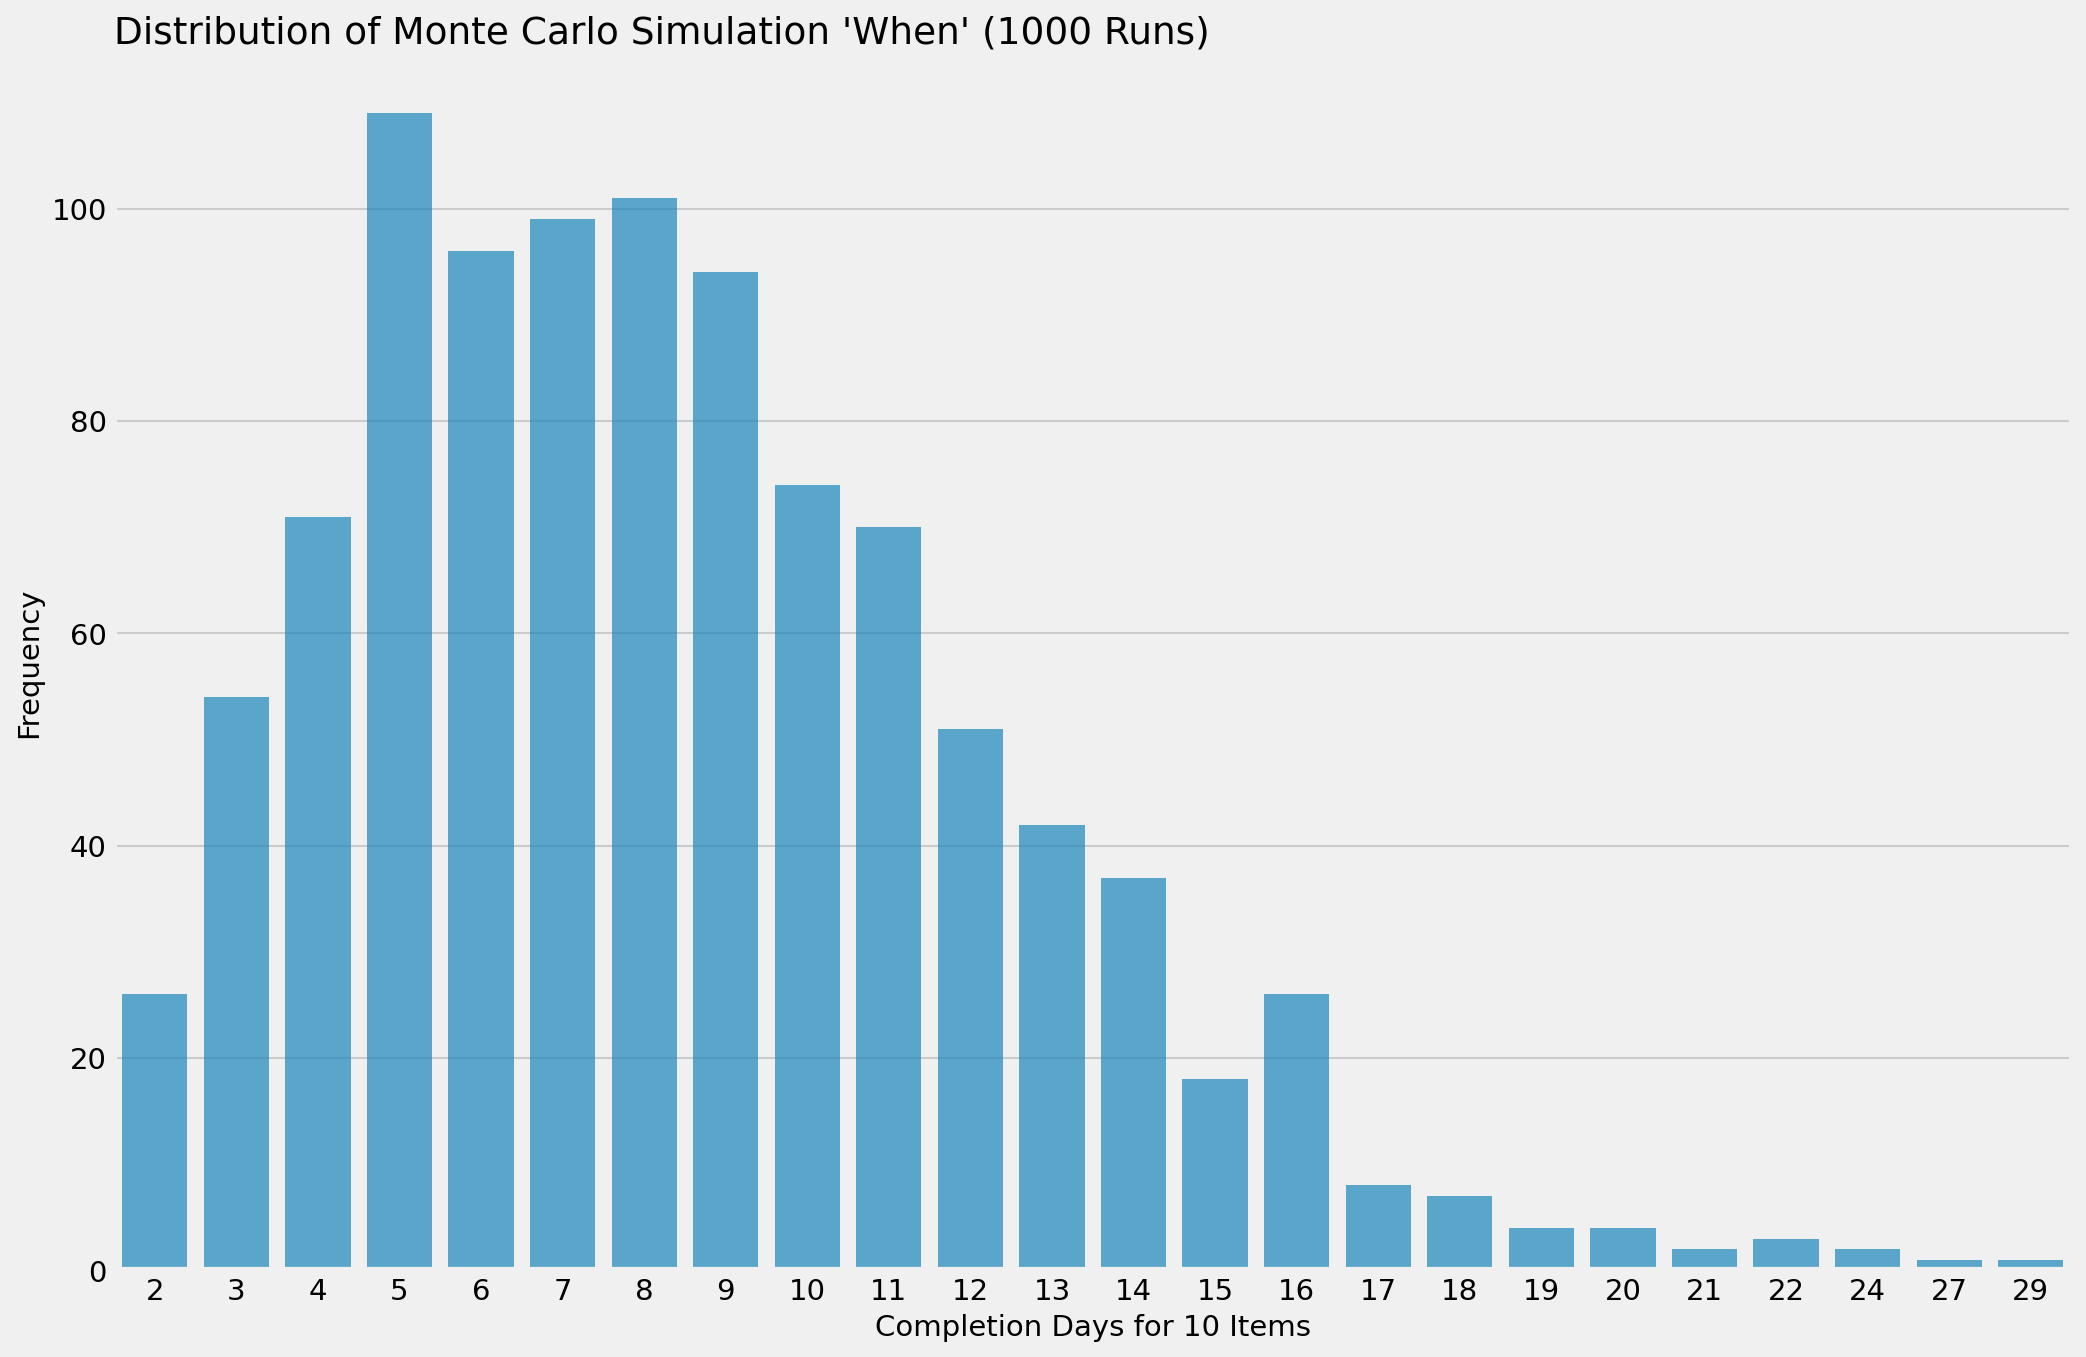

In [39]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

ax = seaborn.barplot(x='Days', y='Frequency', data=distribution_when, color='C0', alpha=0.7)

ax.set_title(f"Distribution of Monte Carlo Simulation 'When' ({SIMULATIONS} Runs)", loc='left',
             fontdict={'size': 18, 'weight': 'normal'})

ax.set_xlabel(f"Completion Days for {SIMULATION_ITEMS} Items")
ax.set_ylabel('Frequency')

In [40]:
ax.figure.savefig('images/distribution-montecarlo-when.png')

Then, we can analyze the probability of completion based on this distribution.

[Text(0, 0, '0%'),
 Text(0, 20, '20%'),
 Text(0, 40, '40%'),
 Text(0, 60, '60%'),
 Text(0, 80, '80%'),
 Text(0, 100, '100%')]

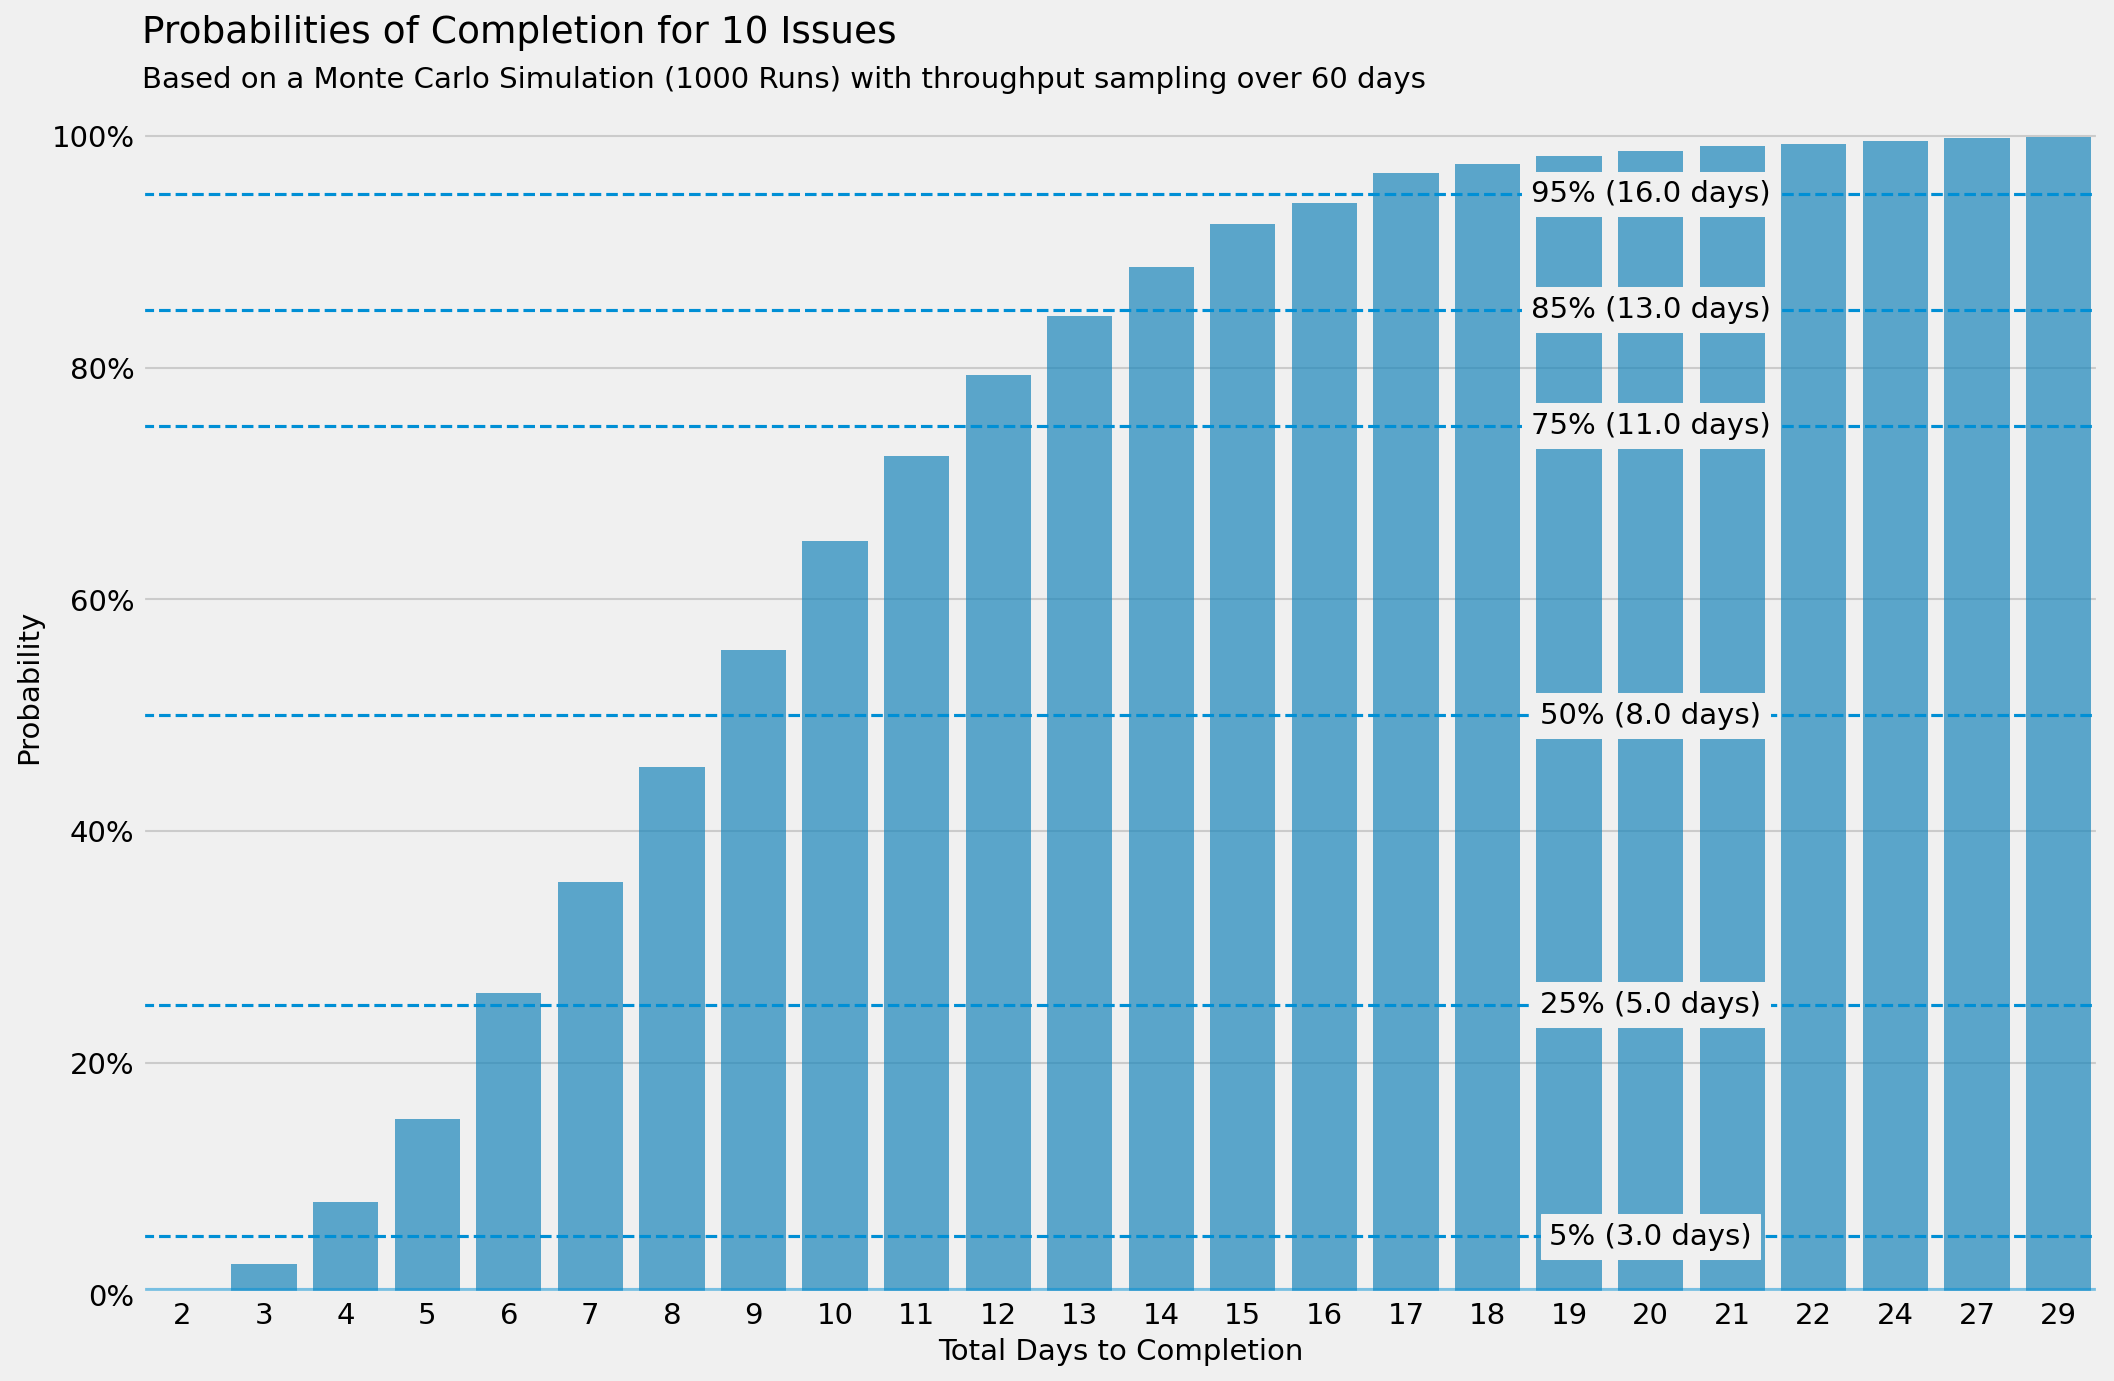

In [41]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

ax = seaborn.barplot(x='Days', y='Probability', data=distribution_when, color='C0', alpha=0.7)

ax.set_title(f"Probabilities of Completion for {SIMULATION_ITEMS} Issues", y=1.02, loc='left',
    fontdict={'size': 18, 'weight': 'normal'})

ax.text(x=0, y=1,
    s=f"Based on a Monte Carlo Simulation ({SIMULATIONS} Runs) with throughput sampling over {LAST_DAYS} days",
    fontsize=14, ha='left', va='center', transform=ax.transAxes);

ax.set_ylabel('Probability')
ax.set_xlabel('Total Days to Completion')
ax.axhline(y=0.5, alpha=.5)
ax.axhline(y=5,   linestyle='--')
ax.axhline(y=25,  linestyle='--')
ax.axhline(y=50,  linestyle='--')
ax.axhline(y=75,  linestyle='--')
ax.axhline(y=85,  linestyle='--')
ax.axhline(y=95,  linestyle='--')

unique_dates = sorted(list(distribution_when['Days'].drop_duplicates()))
date_ticks = range(0, len(unique_dates), len(unique_dates)//10)

xpos = 0.75 * len(unique_dates)

ax.text(y=5, x=xpos, s=f"5% ({(samples.Days.quantile(0.05))} days)",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=25, x=xpos, s=f"25% ({(samples.Days.quantile(0.25))} days)",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=50, x=xpos, s=f"50% ({(samples.Days.quantile(0.5))} days)",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=75, x=xpos, s=f"75% ({(samples.Days.quantile(0.75))} days)",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=85, x=xpos, s=f"85% ({(samples.Days.quantile(0.85))} days)",
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=95, x=xpos, s=f"95% ({(samples.Days.quantile(0.95))} days)",
        va='center', ha='center', backgroundcolor='#F0F0F0')

ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(labels=['0%', '20%', '40%', '60%', '80%', '100%'])



In [42]:
ax.figure.savefig('images/forecast-montecarlo-when.png')

#### [HOW MANY]: How many items will be completed in the next N days?

The Monte Carlo simulation will use the historical distribution of throughput to forecast the future distribution of throughput.

With this simulation, we can compute how many items will be completed in the next N days if the historical distribution holds.

In [43]:
SIMULATION_DAYS = 10 # N
SIMULATIONS = 1000
LAST_DAYS = 60

In [44]:
distribution_how, samples = analysis.forecast_montecarlo_how_many_items(throughput, days=SIMULATION_DAYS, simulations=SIMULATIONS, window=LAST_DAYS)

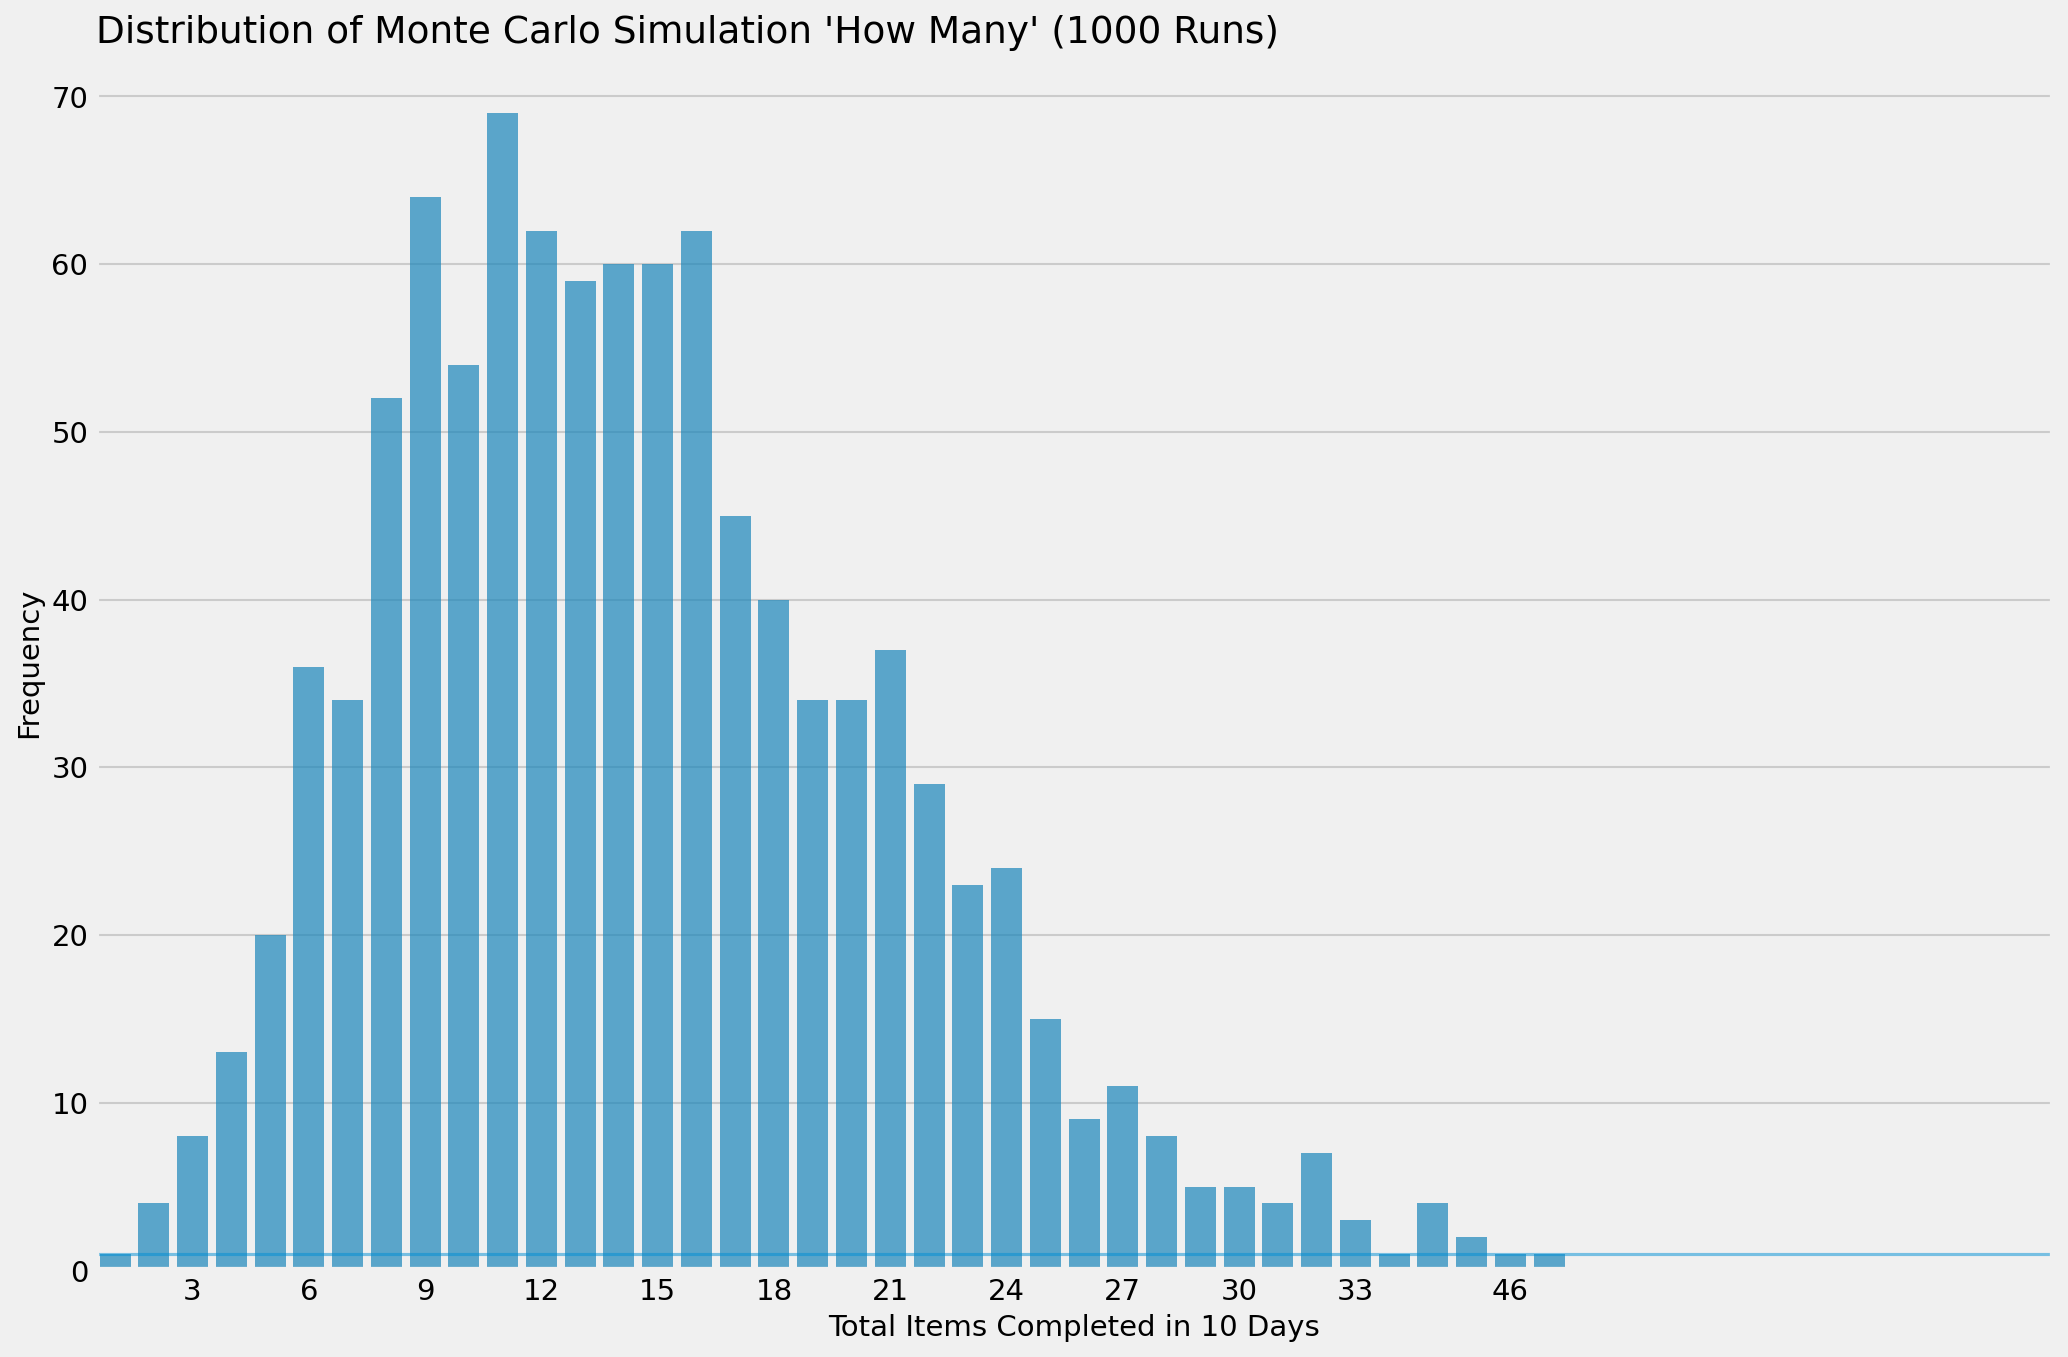

In [45]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

ax = seaborn.barplot(x='Items', y='Frequency', data=distribution_how, color='C0', alpha=0.7)

ax.set_title(f"Distribution of Monte Carlo Simulation 'How Many' ({SIMULATIONS} Runs)", loc='left',
             fontdict={'size': 18, 'weight': 'normal'})

ax.set_xlabel(f"Total Items Completed in {SIMULATION_DAYS} Days")
ax.set_ylabel('Frequency')

ax.set_xticks(distribution_how['Items'][0::len(distribution_how['Items'])//10])

ax.axhline(y=SIMULATIONS*0.001, alpha=.5);

In [46]:
ax.figure.savefig('images/distribution-montecarlo-how.png')

Then, we can analyze the probability of completion based on this distribution.

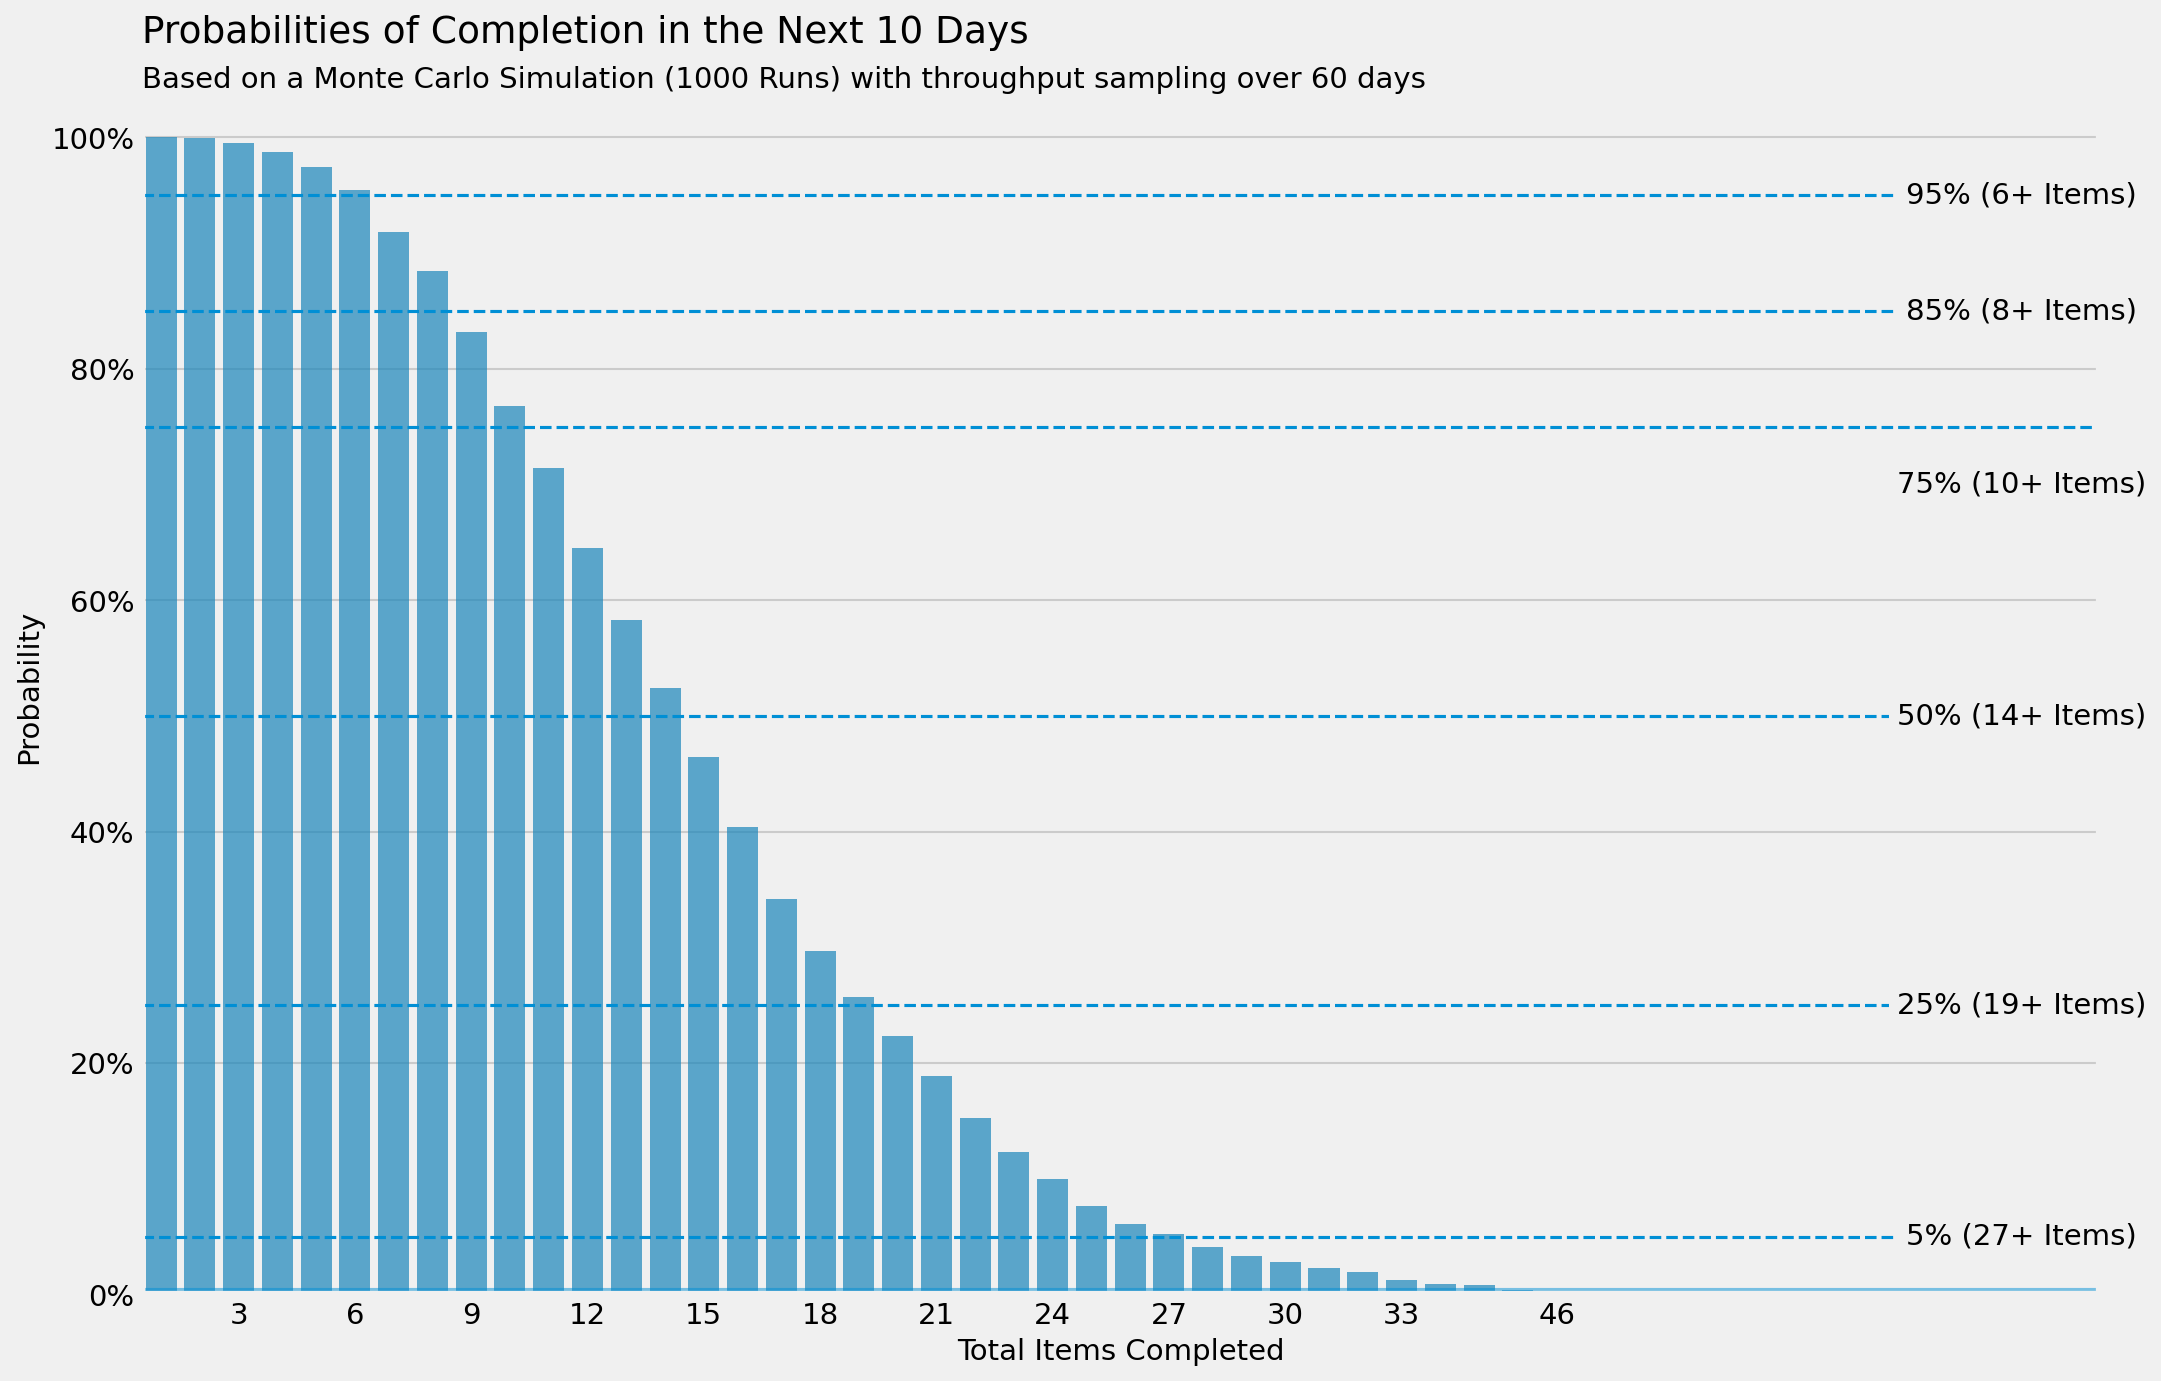

In [47]:
matplotlib.pyplot.figure(dpi=150, figsize=(15, 10))

ax = seaborn.barplot(x='Items', y='Probability', data=distribution_how, color='C0', alpha=0.7)

ax.set_title(f"Probabilities of Completion in the Next {SIMULATION_DAYS} Days", y=1.02, loc='left',
    fontdict={'size': 18, 'weight': 'normal'})
ax.text(x=0, y=1,
    s=f"Based on a Monte Carlo Simulation ({SIMULATIONS} Runs) with throughput sampling over {LAST_DAYS} days",
    fontsize=14, ha='left', va='center', transform=ax.transAxes);

ax.set_ylabel('Probability')
ax.set_xlabel('Total Items Completed')

ax.axhline(y=0.5, alpha=.5)
ax.axhline(y=5,   linestyle='--')
ax.axhline(y=25,  linestyle='--')
ax.axhline(y=50,  linestyle='--')
ax.axhline(y=75,  linestyle='--')
ax.axhline(y=85,  linestyle='--')
ax.axhline(y=95,  linestyle='--')

label_xpos = distribution_how['Items'].max()-2

ax.text(y=5, x=label_xpos, s=f'5%% (%d+ Items)' % samples.Items.quantile(0.95),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=25, x=label_xpos, s=f'25%% (%d+ Items)' % samples.Items.quantile(0.75),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=50, x=label_xpos, s=f'50%% (%d+ Items)' % samples.Items.quantile(0.5),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=70, x=label_xpos, s=f'75%% (%d+ Items)' % samples.Items.quantile(0.25),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=85, x=label_xpos, s=f'85%% (%d+ Items)' % samples.Items.quantile(0.15),
        va='center', ha='center', backgroundcolor='#F0F0F0')
ax.text(y=95, x=label_xpos, s=f'95%% (%d+ Items)' % samples.Items.quantile(0.05),
        va='center', ha='center', backgroundcolor='#F0F0F0')

ax.set_xticks(distribution_how['Items'][0::len(distribution_how['Items'])//10])

ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(labels=['0%', '20%', '40%', '60%', '80%', '100%']);

In [48]:
ax.figure.savefig('images/forecast-montecarlo-how.png')